# Projet 5 étude du marche 

# Importation des données et nettoyage 

In [1]:
from functions import *
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import cluster
from functions import plot_dendrogram
from scipy.cluster.hierarchy import linkage,fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels
import scipy.stats as stats
from scipy.stats import ks_2samp
import seaborn as sns
from matplotlib.collections import LineCollection
#from yellowbrick.cluster import KElbowVisualizer

### Evaluation des compétences

##### Construire et lire un dendogramme

###### Le rapport contient au moins un dendrogramme
 Le rapport contient un découpage du dendrogramme en partitions, le nombre de partitions est argumenté
###### Interpréter une ACP
Le code calcule les centroïdes des groupes de la partition
Le rapport contient une interprétation cohérente des groupes obtenus
Tester l’adéquation à une loi par un test statistique

Le rapport contient le résultat correct d’un test d’adéquation et d’un test de comparaison dans le cas gaussien (attention l’hypothèse gaussienne doit être préalablement vérifiée)

###### Les DataFrame "Dern" représente chaque pays en 2017 par les variables suivantes:
Le pourcentage d'évolution de la population depuis 2017 (négatif si diminué) [pop_evolution]
La disponibilité intérieure en gramme de protéines par habitant par jour [domestic_supply_gprocapitaday]
Le pourcentage de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays [proteine_animal]
La disponibilité intérieure en kcalorie par habitant par jour [domestic_supply_kcalcapitaday]
Le PIB moyen par habitant [pib_hbts]

Cette étude consistera à cibler les pays présentant globalement les "plus hauts chiffres" de chacune de ces 5 variables. En effet, imaginons le "pays cible idéal", il disposerait:
D'une forte disponibilité alimentaire, que ce soit en terme de calories ou de protéines, ce qui nous indiquerait un bon niveau de consommation.
D'un pourcentage important de protéines animales dans la disponibilité totale en protéines, ce qui nous indiquerait une forte consommation de protéine animale.
D'une évolution de la population importante qui nous indiquerait un renouvellement régulier de la clientèle.
D'un bon PIB par habitant, trivial de dire que ce serait avantageux pour nos ventes.
D'un bon rapport entre l'importation de viande de volaille et la production locale, qui nous indique le "niveau d'ouverture" à l'importation de nos produits.

In [2]:
#Paramètres graphiques
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 16

In [3]:
#importe le dataframe population 2016 et 2017
pop= pd.read_csv('population.csv',usecols=("Zone","Année","Valeur"))
pop

,Zone,Année,Valeur
0,Afghanistan,2016,35383
1,Afghanistan,2017,36296
2,Afrique du Sud,2016,56208
3,Afrique du Sud,2017,57010
4,Albanie,2016,2886
...,...,...,...
343,Yémen,2017,27835
344,Zambie,2016,16363
345,Zambie,2017,16854
346,Zimbabwe,2016,14030


In [4]:
#population de l'année 2017
pop17 = pop.loc[pop['Année']== 2017 ,:]
#renomer des variables
p17=pop17.rename(columns={"Zone":"Zone","Année":"Année","Valeur":"V_17"})
p17

,Zone,Année,V_17
1,Afghanistan,2017,36296
3,Afrique du Sud,2017,57010
5,Albanie,2017,2884
7,Algérie,2017,41389
9,Allemagne,2017,82658
...,...,...,...
339,Venezuela (République bolivarienne du),2017,29402
341,Viet Nam,2017,94601
343,Yémen,2017,27835
345,Zambie,2017,16854


In [5]:
#population de l'année 2016
pop16 = pop.loc[pop['Année']== 2016 ,:]
#renomer des variables 
p16=pop16.rename(columns={"Zone":"Zone","Année":"Année","Unité":"Unité","Valeur":"V_16"})
p16

,Zone,Année,V_16
0,Afghanistan,2016,35383
2,Afrique du Sud,2016,56208
4,Albanie,2016,2886
6,Algérie,2016,40551
8,Allemagne,2016,82194
...,...,...,...
338,Venezuela (République bolivarienne du),2016,29851
340,Viet Nam,2016,93640
342,Yémen,2016,27168
344,Zambie,2016,16363


In [6]:
# jointure interne avec la clé zone
populations=pd.merge(p17,p16,on="Zone")
populations

,Zone,Année_x,V_17,Année_y,V_16
0,Afghanistan,2017,36296,2016,35383
1,Afrique du Sud,2017,57010,2016,56208
2,Albanie,2017,2884,2016,2886
3,Algérie,2017,41389,2016,40551
4,Allemagne,2017,82658,2016,82194
...,...,...,...,...,...
169,Venezuela (République bolivarienne du),2017,29402,2016,29851
170,Viet Nam,2017,94601,2016,93640
171,Yémen,2017,27835,2016,27168
172,Zambie,2017,16854,2016,16363


In [7]:
# création d'une colonne croissance démographique 
populations["Croissance_demo"]=((populations["V_17"]-populations["V_16"])/populations["V_17"])*100
populations

,Zone,Année_x,V_17,Année_y,V_16,Croissance_demo
0,Afghanistan,2017,36296,2016,35383,2.515429
1,Afrique du Sud,2017,57010,2016,56208,1.406771
2,Albanie,2017,2884,2016,2886,-0.069348
3,Algérie,2017,41389,2016,40551,2.024693
4,Allemagne,2017,82658,2016,82194,0.561349
...,...,...,...,...,...,...
169,Venezuela (République bolivarienne du),2017,29402,2016,29851,-1.527107
170,Viet Nam,2017,94601,2016,93640,1.015845
171,Yémen,2017,27835,2016,27168,2.396264
172,Zambie,2017,16854,2016,16363,2.913255


In [8]:
# énumérer les colonnes d'un dataframe 
for idx,column in enumerate(populations.columns):
       print(idx,column)

0 Zone
1 Année_x
2 V_17
3 Année_y
4 V_16
5 Croissance_demo


In [9]:
# création de dataframe pays_population
popu=populations.iloc[:,[0,5]]
popu

,Zone,Croissance_demo
0,Afghanistan,2.515429
1,Afrique du Sud,1.406771
2,Albanie,-0.069348
3,Algérie,2.024693
4,Allemagne,0.561349
...,...,...
169,Venezuela (République bolivarienne du),-1.527107
170,Viet Nam,1.015845
171,Yémen,2.396264
172,Zambie,2.913255


In [10]:
#importation de dataframe animaux
animal= pd.read_csv('animaux.csv',usecols=("Élément","Zone","Année","Unité","Valeur"))
animal['Origine']='animal' # création d'une colonne Origine 
animal

,Zone,Élément,Année,Unité,Valeur,Origine
0,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,22.00,animal
1,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,1.55,animal
2,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,28.00,animal
3,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,1.70,animal
4,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,animal
...,...,...,...,...,...,...
7515,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,animal
7516,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,animal
7517,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,animal
7518,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,animal


In [11]:
#importation de dataframe vegetaux 
vegetaux= pd.read_csv('vegetaux.csv',usecols=("Élément","Zone","Année","Unité","Valeur"))
vegetaux['Origine']='vegetal' # et création d'une colonne Origine
vegetaux

,Zone,Élément,Année,Unité,Valeur,Origine
0,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,1358.00,vegetal
1,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,36.53,vegetal
2,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,123.00,vegetal
3,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,2.38,vegetal
4,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,12.00,vegetal
...,...,...,...,...,...,...
21952,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,vegetal
21953,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,vegetal
21954,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,vegetal
21955,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,1.00,vegetal


In [12]:
#on va fusionner vetegataux et animal avec la fonction append pour former  Bilan alimentaire 
BilanAliment=vegetaux.append(animal, ignore_index=True)
BilanAliment

,Zone,Élément,Année,Unité,Valeur,Origine
0,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,1358.00,vegetal
1,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,36.53,vegetal
2,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,123.00,vegetal
3,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,2.38,vegetal
4,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,12.00,vegetal
...,...,...,...,...,...,...
29472,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,animal
29473,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,animal
29474,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,2017,g/personne/jour,0.00,animal
29475,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),2017,Kcal/personne/jour,0.00,animal


In [13]:
#on va faire tableau croisé en indexant zone,année et origine  
BilanAlim_pivot=BilanAliment.pivot_table(index=['Zone','Année','Origine'],columns="Élément",values='Valeur',aggfunc=sum).reset_index()
BilanAlim_pivot

Élément,Zone,Année,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
0,Afghanistan,2017,animal,194.0,11.14
1,Afghanistan,2017,vegetal,1854.0,45.04
2,Afrique du Sud,2017,animal,465.0,35.30
3,Afrique du Sud,2017,vegetal,2469.0,48.32
4,Albanie,2017,animal,1043.0,64.07
...,...,...,...,...,...
343,États-Unis d'Amérique,2017,vegetal,2752.0,39.78
344,Éthiopie,2017,animal,103.0,6.62
345,Éthiopie,2017,vegetal,2229.0,59.61
346,Îles Salomon,2017,animal,197.0,15.71


In [14]:
# groupe les elément de chaque pays 
Bilan_animal_vege=BilanAlim_pivot.groupby("Zone").mean().reset_index()
Bilan_animal_vege

Élément,Zone,Année,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
0,Afghanistan,2017,1024.0,28.090
1,Afrique du Sud,2017,1467.0,41.810
2,Albanie,2017,1694.5,59.060
3,Algérie,2017,1670.0,46.405
4,Allemagne,2017,1772.5,51.910
...,...,...,...,...
169,Émirats arabes unis,2017,1670.5,56.395
170,Équateur,2017,1298.5,33.230
171,États-Unis d'Amérique,2017,1887.0,56.550
172,Éthiopie,2017,1166.0,33.115


In [15]:
#selection que le produit d'origine animal 
proteine_animal = BilanAlim_pivot.loc[BilanAlim_pivot['Origine']=='animal',:]
proteine_animal

Élément,Zone,Année,Origine,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour)
0,Afghanistan,2017,animal,194.0,11.14
2,Afrique du Sud,2017,animal,465.0,35.30
4,Albanie,2017,animal,1043.0,64.07
6,Algérie,2017,animal,418.0,26.71
8,Allemagne,2017,animal,1071.0,62.77
...,...,...,...,...,...
338,Émirats arabes unis,2017,animal,703.0,51.54
340,Équateur,2017,animal,529.0,30.84
342,États-Unis d'Amérique,2017,animal,1022.0,73.32
344,Éthiopie,2017,animal,103.0,6.62


In [16]:
# création d'un colonne propo_potéine
Bilan_animal_vege['prop_protéine(anim/tt)']=(proteine_animal['Disponibilité de protéines en quantité (g/personne/jour)']/Bilan_animal_vege['Disponibilité de protéines en quantité (g/personne/jour)'])*100
Bilan_animal_vege

Élément,Zone,Année,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),prop_protéine(anim/tt)
0,Afghanistan,2017,1024.0,28.090,39.658241
1,Afrique du Sud,2017,1467.0,41.810,NaN
2,Albanie,2017,1694.5,59.060,59.769726
3,Algérie,2017,1670.0,46.405,NaN
4,Allemagne,2017,1772.5,51.910,123.425159
...,...,...,...,...,...
169,Émirats arabes unis,2017,1670.5,56.395,NaN
170,Équateur,2017,1298.5,33.230,66.355703
171,États-Unis d'Amérique,2017,1887.0,56.550,NaN
172,Éthiopie,2017,1166.0,33.115,31.103729


In [17]:
# on vérifier si le dataframe n'a pas des valeurs manquantes
Bilan_animal_vege.isnull().sum()

Élément
Zone                                                         0
Année                                                        0
Disponibilité alimentaire (Kcal/personne/jour)               0
Disponibilité de protéines en quantité (g/personne/jour)     0
prop_protéine(anim/tt)                                      87
dtype: int64

In [18]:
# avant de calcule la moyenne on garde que les colonnes non vides
moyi=Bilan_animal_vege.dropna()

In [19]:
# calcule de la moyenne
moy=moyi["prop_protéine(anim/tt)"].mean()
moy

103.45547520549283

In [20]:
# imputation par la moyenne  car c'est la moyenne est le ciffre le plus preche de l'ensemble 
Bilan_animal_vege['prop_protéine(anim/tt)']=Bilan_animal_vege["prop_protéine(anim/tt)"].fillna(round(moy,2))

In [21]:
#on vérifier les valeurs manquantes
Bilan_animal_vege.isnull().sum()

Élément
Zone                                                        0
Année                                                       0
Disponibilité alimentaire (Kcal/personne/jour)              0
Disponibilité de protéines en quantité (g/personne/jour)    0
prop_protéine(anim/tt)                                      0
dtype: int64

In [22]:
#disponibilité alimentaire en calories par habitant
Bilan_animal_vege["Disponibilité alimentaire (cal/personne/an)"]=Bilan_animal_vege["Disponibilité alimentaire (Kcal/personne/jour)"]*365*1000

In [23]:
#disponibilité alimentaire en protéines par habitant
Bilan_animal_vege['Disponibilité de protéines en quantité (kg/personne/an)']=Bilan_animal_vege['Disponibilité de protéines en quantité (g/personne/jour)']*365*1000

In [24]:
for idx,column in enumerate(Bilan_animal_vege.columns):
       print(idx,column)

0 Zone
1 Année
2 Disponibilité alimentaire (Kcal/personne/jour)
3 Disponibilité de protéines en quantité (g/personne/jour)
4 prop_protéine(anim/tt)
5 Disponibilité alimentaire (cal/personne/an)
6 Disponibilité de protéines en quantité (kg/personne/an)


In [25]:
Bilan=Bilan_animal_vege.iloc[:,[0,4,5,6]]
Bilan

Élément,Zone,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an)
0,Afghanistan,39.658241,373760000.0,10252850.0
1,Afrique du Sud,103.460000,535455000.0,15260650.0
2,Albanie,59.769726,618492500.0,21556900.0
3,Algérie,103.460000,609550000.0,16937825.0
4,Allemagne,123.425159,646962500.0,18947150.0
...,...,...,...,...
169,Émirats arabes unis,103.460000,609732500.0,20584175.0
170,Équateur,66.355703,473952500.0,12128950.0
171,États-Unis d'Amérique,103.460000,688755000.0,20640750.0
172,Éthiopie,31.103729,425590000.0,12086975.0


In [26]:
# mettre ensemble  les deux dataframes en utilisany la jointure interne
Bilan_f=pd.merge(Bilan,popu,on='Zone' ) 
Bilan_f

,Zone,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
0,Afghanistan,39.658241,373760000.0,10252850.0,2.515429
1,Afrique du Sud,103.460000,535455000.0,15260650.0,1.406771
2,Albanie,59.769726,618492500.0,21556900.0,-0.069348
3,Algérie,103.460000,609550000.0,16937825.0,2.024693
4,Allemagne,123.425159,646962500.0,18947150.0,0.561349
...,...,...,...,...,...
169,Émirats arabes unis,103.460000,609732500.0,20584175.0,1.328133
170,Équateur,66.355703,473952500.0,12128950.0,1.751564
171,États-Unis d'Amérique,103.460000,688755000.0,20640750.0,0.636449
172,Éthiopie,31.103729,425590000.0,12086975.0,2.628759


In [27]:
# renomes les colonnes
Bilan_p=Bilan_f.rename(columns={"Zone":"Pays"})
Bilan_p

,Pays,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
0,Afghanistan,39.658241,373760000.0,10252850.0,2.515429
1,Afrique du Sud,103.460000,535455000.0,15260650.0,1.406771
2,Albanie,59.769726,618492500.0,21556900.0,-0.069348
3,Algérie,103.460000,609550000.0,16937825.0,2.024693
4,Allemagne,123.425159,646962500.0,18947150.0,0.561349
...,...,...,...,...,...
169,Émirats arabes unis,103.460000,609732500.0,20584175.0,1.328133
170,Équateur,66.355703,473952500.0,12128950.0,1.751564
171,États-Unis d'Amérique,103.460000,688755000.0,20640750.0,0.636449
172,Éthiopie,31.103729,425590000.0,12086975.0,2.628759


In [28]:
# importation de dataframe 
impor_vol= pd.read_csv('volaille.csv',usecols=("Zone","Valeur"))
impor_vol

,Zone,Valeur
0,Afghanistan,29
1,Afrique du Sud,514
2,Albanie,20
3,Algérie,2
4,Allemagne,842
...,...,...
168,Venezuela (République bolivarienne du),23
169,Viet Nam,357
170,Yémen,82
171,Zambie,12


In [29]:
# renomes les colonnes
impor=impor_vol.rename(columns={"Zone":"Pays","Valeur":"impor_volailles"})
impor

,Pays,impor_volailles
0,Afghanistan,29
1,Afrique du Sud,514
2,Albanie,20
3,Algérie,2
4,Allemagne,842
...,...,...
168,Venezuela (République bolivarienne du),23
169,Viet Nam,357
170,Yémen,82
171,Zambie,12


In [30]:
# importe le dataframe
prod_vol= pd.read_csv('Volaille_prod.csv',usecols=("Zone","Valeur"))
prod_vol

,Zone,Valeur
0,Afghanistan,28
1,Afrique du Sud,1665
2,Albanie,13
3,Algérie,297
4,Allemagne,1514
...,...,...
167,Venezuela (République bolivarienne du),462
168,Viet Nam,892
169,Yémen,170
170,Zambie,49


In [31]:
#importe le dataframe
prod_f=prod_vol.rename(columns={"Zone":"Pays","Valeur":"Prod_Volaille"})
prod_f

,Pays,Prod_Volaille
0,Afghanistan,28
1,Afrique du Sud,1665
2,Albanie,13
3,Algérie,297
4,Allemagne,1514
...,...,...
167,Venezuela (République bolivarienne du),462
168,Viet Nam,892
169,Yémen,170
170,Zambie,49


In [32]:
PIB= pd.read_csv('PIB_Hab.csv',usecols=("Zone","Valeur"))
PIB

,Zone,Valeur
0,Afghanistan,624.105029
1,Afrique du Sud,7525.516250
2,Albanie,4773.659501
3,Algérie,4806.918145
4,Allemagne,47298.378965
...,...,...
206,Venezuela (République bolivarienne du),8892.951215
207,Viet Nam,1834.651389
208,Yémen,490.893541
209,Zambie,1637.388806


In [33]:
PIB.isnull().sum()

Zone      0
Valeur    0
dtype: int64

In [34]:
PIB_f=PIB.rename(columns={"Zone":"Pays","Valeur":"PIB_2017"})
PIB_f

,Pays,PIB_2017
0,Afghanistan,624.105029
1,Afrique du Sud,7525.516250
2,Albanie,4773.659501
3,Algérie,4806.918145
4,Allemagne,47298.378965
...,...,...
206,Venezuela (République bolivarienne du),8892.951215
207,Viet Nam,1834.651389
208,Yémen,490.893541
209,Zambie,1637.388806


In [35]:
final_impor=pd.merge(impor,Bilan_p,on="Pays")

In [36]:
final_prod=pd.merge(prod_f,final_impor,on="Pays")

In [37]:
final_tt=pd.merge(PIB_f,final_prod,on="Pays")
final_tt

,Pays,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
0,Afghanistan,624.105029,28,29,39.658241,373760000.0,10252850.0,2.515429
1,Afrique du Sud,7525.516250,1665,514,103.460000,535455000.0,15260650.0,1.406771
2,Albanie,4773.659501,13,20,59.769726,618492500.0,21556900.0,-0.069348
3,Algérie,4806.918145,297,2,103.460000,609550000.0,16937825.0,2.024693
4,Allemagne,47298.378965,1514,842,123.425159,646962500.0,18947150.0,0.561349
...,...,...,...,...,...,...,...,...
165,Venezuela (République bolivarienne du),8892.951215,462,23,103.460000,405515000.0,10207225.0,-1.527107
166,Viet Nam,1834.651389,892,357,100.145108,540200000.0,17607600.0,1.015845
167,Yémen,490.893541,170,82,103.460000,377227500.0,9329400.0,2.396264
168,Zambie,1637.388806,49,12,63.753388,362627500.0,10774800.0,2.913255


In [38]:
ff=final_tt.groupby("Pays").mean()
ff

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
Pays,,,,,,,
Afghanistan,624.105029,28,29,39.658241,373760000.0,10252850.0,2.515429
Afrique du Sud,7525.516250,1665,514,103.460000,535455000.0,15260650.0,1.406771
Albanie,4773.659501,13,20,59.769726,618492500.0,21556900.0,-0.069348
Algérie,4806.918145,297,2,103.460000,609550000.0,16937825.0,2.024693
Allemagne,47298.378965,1514,842,123.425159,646962500.0,18947150.0,0.561349
...,...,...,...,...,...,...,...
Émirats arabes unis,41197.178798,47,465,103.460000,609732500.0,20584175.0,1.328133
Équateur,5269.600089,340,0,66.355703,473952500.0,12128950.0,1.751564
États-Unis d'Amérique,53469.316622,21914,123,103.460000,688755000.0,20640750.0,0.636449


In [39]:
# on vérifie qu'il y a des doublons pour la chine comme dans le projet 3
ff.loc[ff.index.str.contains('Chine')]

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
Pays,,,,,,,
Chine,7389.099404,20069,1543,103.460000,577977500.0,18242700.0,0.488908
Chine - RAS de Hong-Kong,38067.522234,24,907,86.328182,596227500.0,24801750.0,0.848618
Chine - RAS de Macao,55936.511322,4,23,103.460000,601885000.0,20018425.0,1.605136
"Chine, continentale",7207.358468,19384,452,103.460000,577612500.0,18273725.0,0.490703


In [40]:
# on va supprimer Chine 
Pays=ff.drop('Chine')
Pays

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
Pays,,,,,,,
Afghanistan,624.105029,28,29,39.658241,373760000.0,10252850.0,2.515429
Afrique du Sud,7525.516250,1665,514,103.460000,535455000.0,15260650.0,1.406771
Albanie,4773.659501,13,20,59.769726,618492500.0,21556900.0,-0.069348
Algérie,4806.918145,297,2,103.460000,609550000.0,16937825.0,2.024693
Allemagne,47298.378965,1514,842,123.425159,646962500.0,18947150.0,0.561349
...,...,...,...,...,...,...,...
Émirats arabes unis,41197.178798,47,465,103.460000,609732500.0,20584175.0,1.328133
Équateur,5269.600089,340,0,66.355703,473952500.0,12128950.0,1.751564
États-Unis d'Amérique,53469.316622,21914,123,103.460000,688755000.0,20640750.0,0.636449


In [41]:
# on vérifier qu'on a supprime chine 
Pays.loc[Pays.index.str.contains('Chine')]

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
Pays,,,,,,,
Chine - RAS de Hong-Kong,38067.522234,24,907,86.328182,596227500.0,24801750.0,0.848618
Chine - RAS de Macao,55936.511322,4,23,103.460000,601885000.0,20018425.0,1.605136
"Chine, continentale",7207.358468,19384,452,103.460000,577612500.0,18273725.0,0.490703


In [42]:
# informations 
Pays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, Afghanistan to Îles Salomon
Data columns (total 7 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   PIB_2017                                                 169 non-null    float64
 1   Prod_Volaille                                            169 non-null    int64  
 2   impor_volailles                                          169 non-null    int64  
 3   prop_protéine(anim/tt)                                   169 non-null    float64
 4   Disponibilité alimentaire (cal/personne/an)              169 non-null    float64
 5   Disponibilité de protéines en quantité (kg/personne/an)  169 non-null    float64
 6   Croissance_demo                                          169 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 10.6+ KB


In [43]:
#verification des valeurs manquante
Pays.isnull().sum()

PIB_2017                                                   0
Prod_Volaille                                              0
impor_volailles                                            0
prop_protéine(anim/tt)                                     0
Disponibilité alimentaire (cal/personne/an)                0
Disponibilité de protéines en quantité (kg/personne/an)    0
Croissance_demo                                            0
dtype: int64

# Analyse des données

In [44]:
# forme des données utilisées
Pays.shape

(169, 7)

In [45]:
# statistique descriptives
Pays.describe().round(2)

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
count,169.00,169.00,169.00,169.00,1.690000e+02,169.00,169.00
mean,14053.15,725.60,89.43,103.58,5.242404e+08,14947279.14,1.23
std,19396.72,2544.29,187.18,51.52,8.264359e+07,3787160.92,1.10
min,335.04,0.00,0.00,20.13,3.272225e+08,7535425.00,-1.58
25%,1834.65,14.00,3.00,88.69,4.642800e+08,11798625.00,0.38
50%,5854.84,68.00,16.00,103.46,5.219500e+08,15070850.00,1.16
75%,15802.91,361.00,82.00,103.46,5.964100e+08,17775500.00,2.06
max,108872.32,21914.00,1069.00,397.29,6.997050e+08,26495350.00,4.01


##### La plus parts des pays ont une croissance de la population de  1.2 % ,on regarde la moyenne et la médiane 
##### En moyenne les pays produisent 738 milliers de tonnes et importe 91 m tonnes et la disponibilité de cal par personne est de 5.2e8 calorie ,disponibilité de protéine de 1.4 kg par personne dont 100.8% de protéine d'origine animale et le PIB par habitat de 13659 U$ 
##### on remarque que la plus part des pays importe moins qu'ils produisent si on regarde Q3 avec un taux de croissance de la population qui est autour de 2 %.
##### Donc on va choisir le pays dont la prop_protéine(anim/tt) car la moitie de la population consomme plus de viande si on regarde la médiane  et Q3 et le min est 42.2%

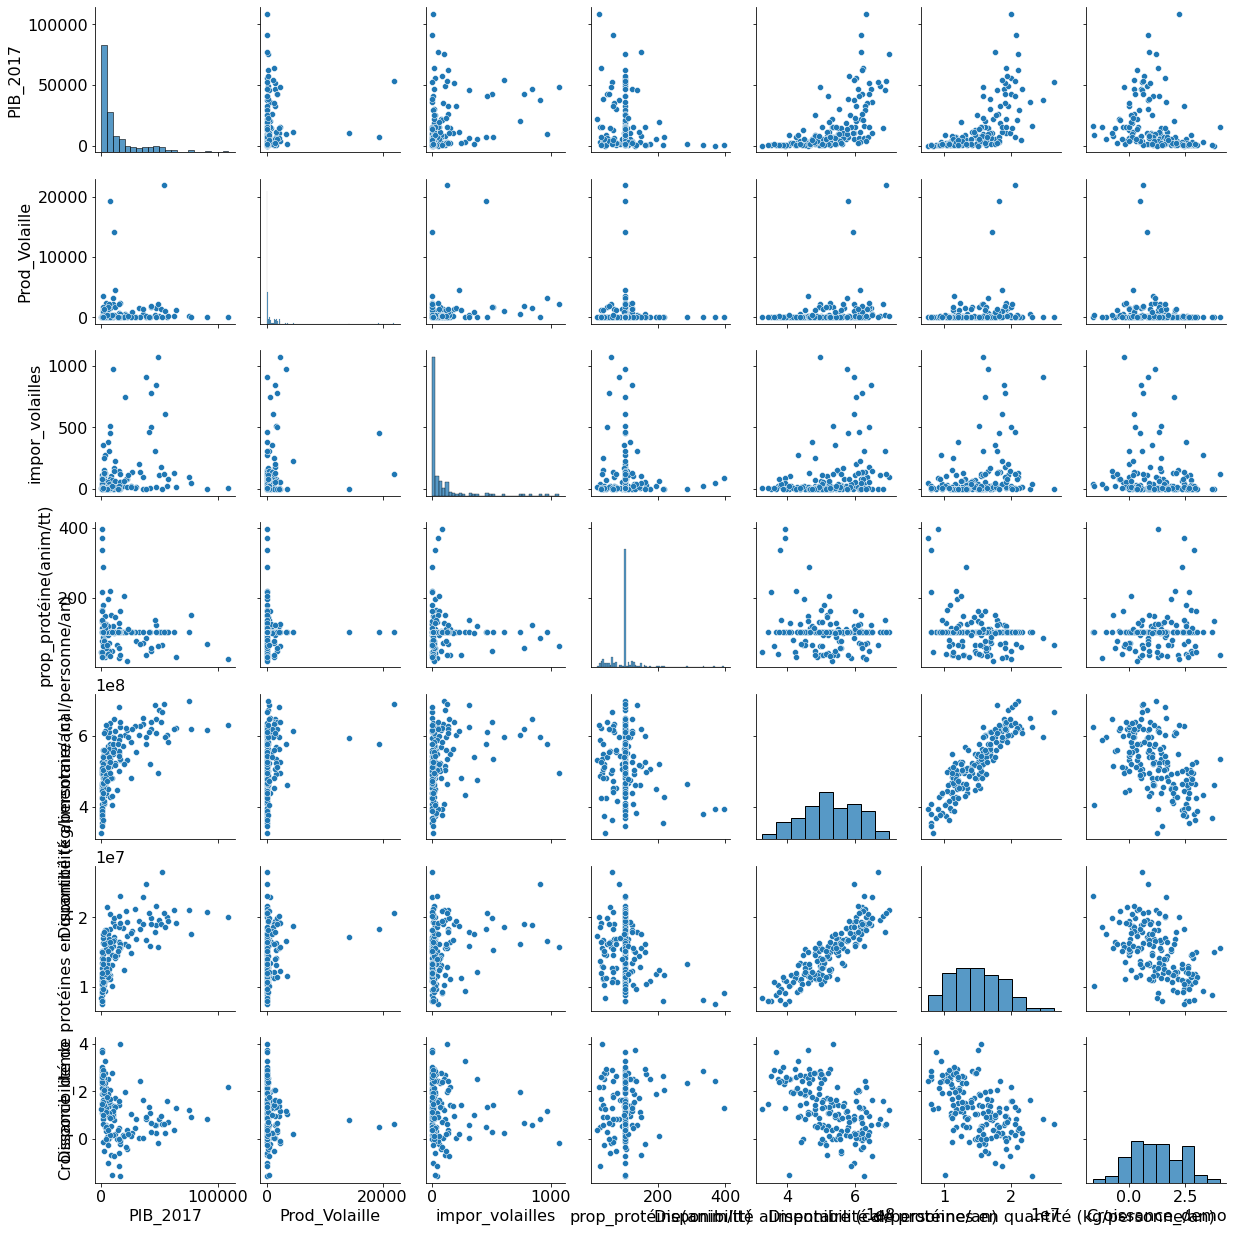

In [46]:
#preséntation graphiques univarie et bivaries 
sns.pairplot(Pays, kind="scatter")
plt.savefig("image_scatter")
plt.show()

###### dispo_cal, croissance_population et disponibilité en protéine sont les varible bien dispersées (il y a une consantrationde gauceh vers à droite )
###### les variable dispo_cal et dispo protéin sont colerés positivement et croissance_pop est coleré negativement avec dispo_cal et dispo_protéine

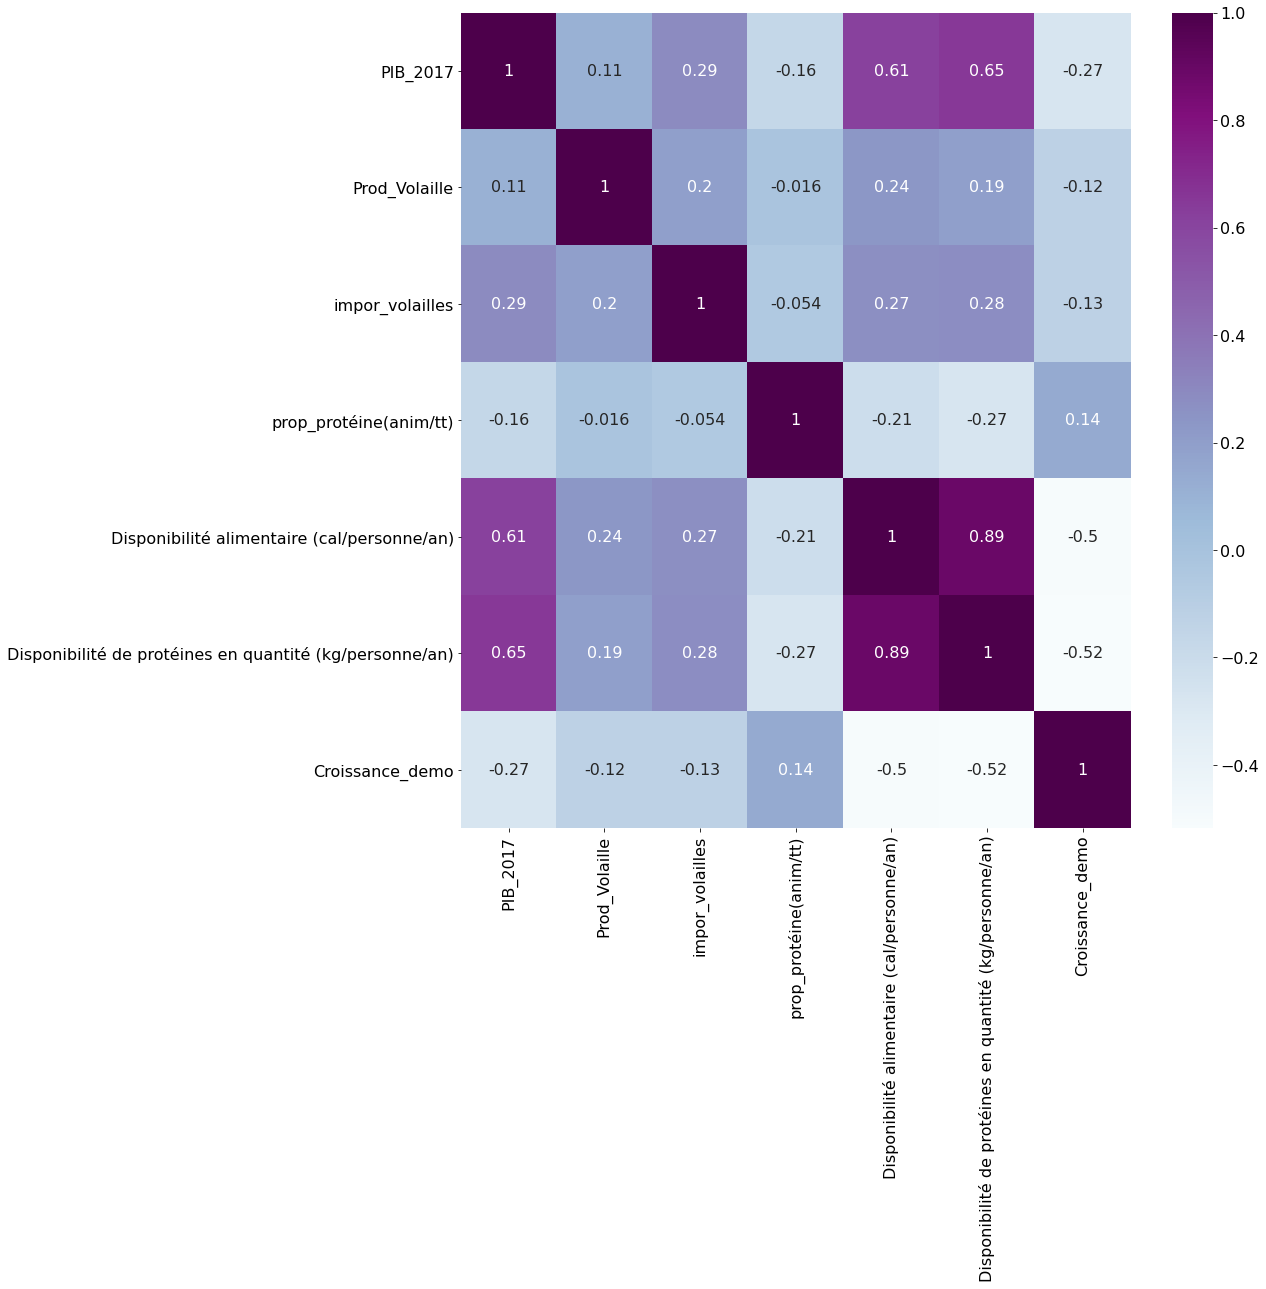

In [47]:
# matrice de corrélation
tt_corr=Pays.corr()
sns.heatmap(tt_corr,annot=True ,cmap="BuPu")
plt.savefig("image_matrice corr")
plt.show()

#### on voit que plus c'est bleu fonce plus il y a une correlation entre variable ,si on regarder bien on remarque que'il y a une forte corrélation positive entre dispo_ali_cal et dispo-proéine (0.9) ensuite il ya une correlarion positive entre dispo_alim_cal et Pib/hab de 0.61 et dispoi_protéin et Pib/hab(0.64) et plus le blanch plus la corrélation est négative l'exemple c'est la corrélation entre coissance_pop et dispo_protéine qui est de (-0.53) et coissance_popu et dispo_cal(-0.51)

# CAH_Classification

## préparation des données pour le clustering

In [48]:
# préparation des données pour le clustering
X = Pays.values

## Les données Centre et Réduction

In [49]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
names =Pays.index

In [50]:
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Viet Nam', 'Yémen', 'Zambie', 'Zimbabwe', 'Égypte',
       'Émirats arabes unis', 'Équateur', 'États-Unis d'Amérique', 'Éthiopie',
       'Îles Salomon'],
      dtype='object', name='Pays', length=169)

## Clustering hiérarchique et Dendrogramme


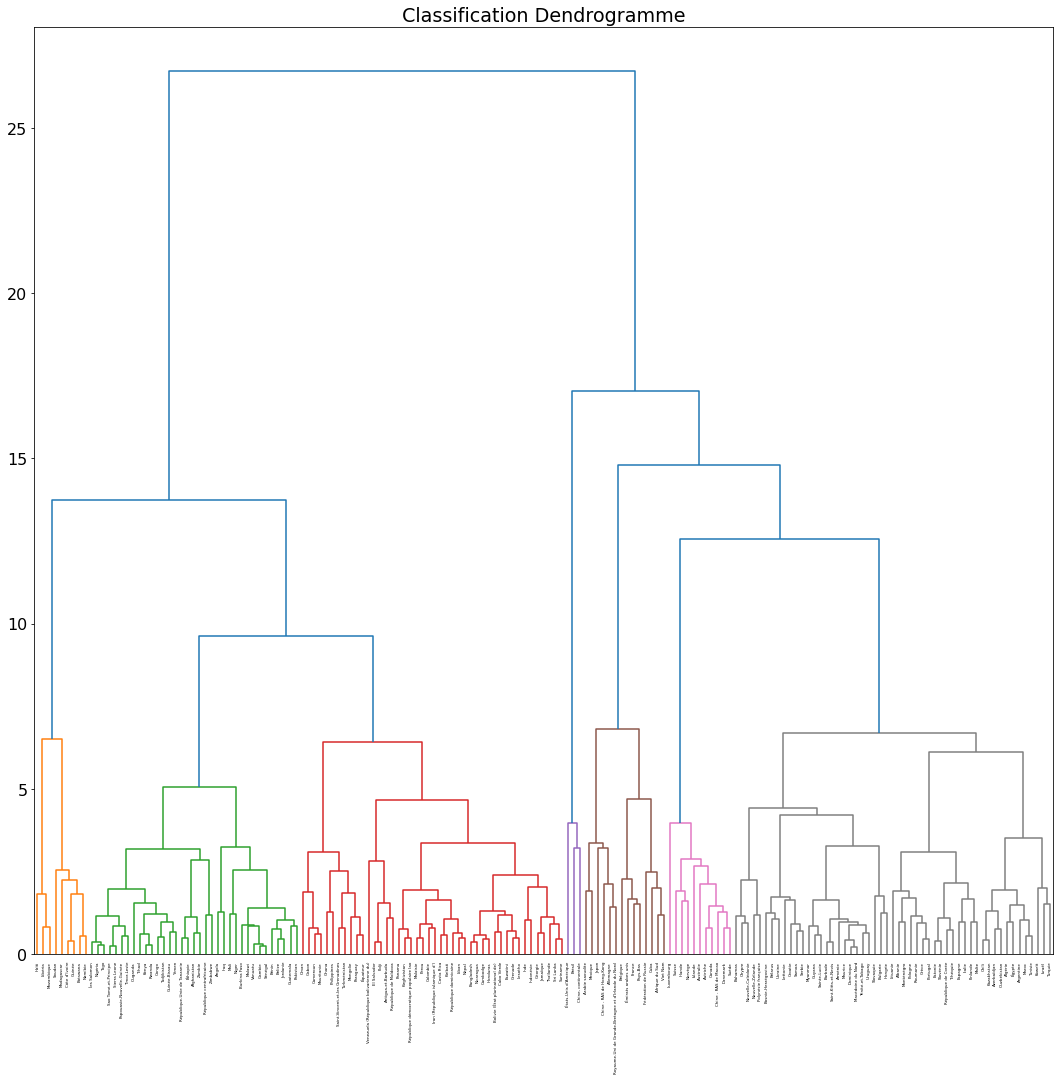

In [51]:
from scipy.cluster import hierarchy
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
# Affichage du dendrogramme
hierarchy.dendrogram(Z,leaf_font_size=4 ,labels=names,color_threshold=7)
plt.tight_layout()
plt.title('Classification Dendrogramme')
plt.savefig("Dendrogramme_p5")

In [52]:
#moyenne
print(np.mean(X_scaled,axis=0))

[ 6.30659233e-17 -5.25549361e-18 -2.10219744e-17 -6.72949533e-17
 -3.36351591e-16  1.89197770e-16 -5.25549361e-18]


In [53]:
#écart-type
print(np.std(X_scaled,axis=0,ddof=0))

[1. 1. 1. 1. 1. 1. 1.]


##  Le Coupage du Dendrogramme en 5 clusters

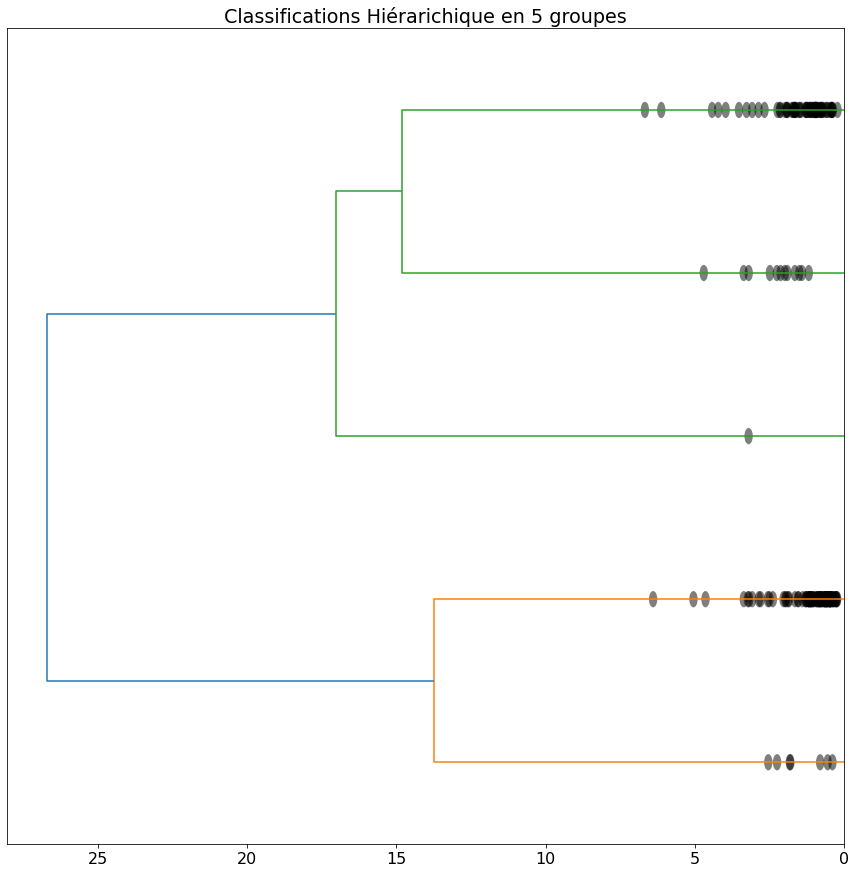

In [54]:
# Coupage du dendrogramme en 5 clusters
dendrogram(Z,
    truncate_mode='lastp',  # afficher uniquement les p derniers clusters
    p=5,  # afficher le p clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,orientation='left'  # to get a distribution impression in truncated branches
)
plt.title("Classifications Hiérarichique en 5 groupes")
plt.savefig("image_dendrogramme")
plt.show()

#### on n'a pas besoin d'utiliser la méhodes de coude ici car on nous a déjà demandé de faire 5 clusters

In [55]:
#Coupage du dendrogramme en 5 clusters
groupes_cah = fcluster(Z,5,criterion='maxclust')
# ajout des clusters à le table
print('Numérotation de nos groupes : ' + str(np.unique(groupes_cah)))

Numérotation de nos groupes : [1 2 3 4 5]


In [56]:
#index triés des groupes
idg = np.argsort(groupes_cah)

In [57]:
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Viet Nam', 'Yémen', 'Zambie', 'Zimbabwe', 'Égypte',
       'Émirats arabes unis', 'Équateur', 'États-Unis d'Amérique', 'Éthiopie',
       'Îles Salomon'],
      dtype='object', name='Pays', length=169)

In [58]:
#affichage des observations et leurs groupes
pp_groupes_cah = pd.DataFrame(names[idg], groupes_cah[idg]).reset_index()
pp_groupes_cah = pp_groupes_cah.rename(columns={'index':'Groupe'})
pp_groupes_cah 

,Groupe,Pays
0,1,Haïti
1,1,Madagascar
2,1,Libéria
3,1,Botswana
4,1,Mozambique
...,...,...
164,5,Ouzbékistan
165,5,Chypre
166,5,Grèce
167,5,Bosnie-Herzégovine


In [59]:
Dern=pd.merge(Pays,pp_groupes_cah,on="Pays")
Dern["Groupe"]=Dern.Groupe.astype("category")# changement de cluster en variable 
p=Dern.Groupe.value_counts() # taille des differents groupes ou clusters
p

2    79
5    64
4    14
1     9
3     3
Name: Groupe, dtype: int64

In [60]:
# caractéristique de centre des classe (centroide)
group =Dern.groupby('Groupe').mean()
group

,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo
Groupe,,,,,,,
1,2163.433304,37.666667,25.666667,263.092636,4.295442e+08,1.013544e+07,2.308058
2,3532.554922,283.670886,33.088608,92.968058,4.667957e+08,1.222965e+07,1.813038
3,23846.296161,18488.666667,192.666667,103.460000,6.197700e+08,1.869652e+07,0.643720
4,29936.359170,1419.142857,615.214286,95.619450,5.990562e+08,1.828859e+07,0.717739
5,24778.001578,383.500000,48.078125,95.999837,5.876215e+08,1.807186e+07,0.490126


###### on remarque que  les pays dont prop_protéine(anim/tt) est plus éléve   1 et 3 et la disponibilité alimentaire en calorie est plus éleve pour le groupe 3 et groupe 5,4 aussi sont interessant car le PIB par habitat est plus éléve pour groupe 3,4 et 5 donc on va prendre le groupe 3 et 4 .

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


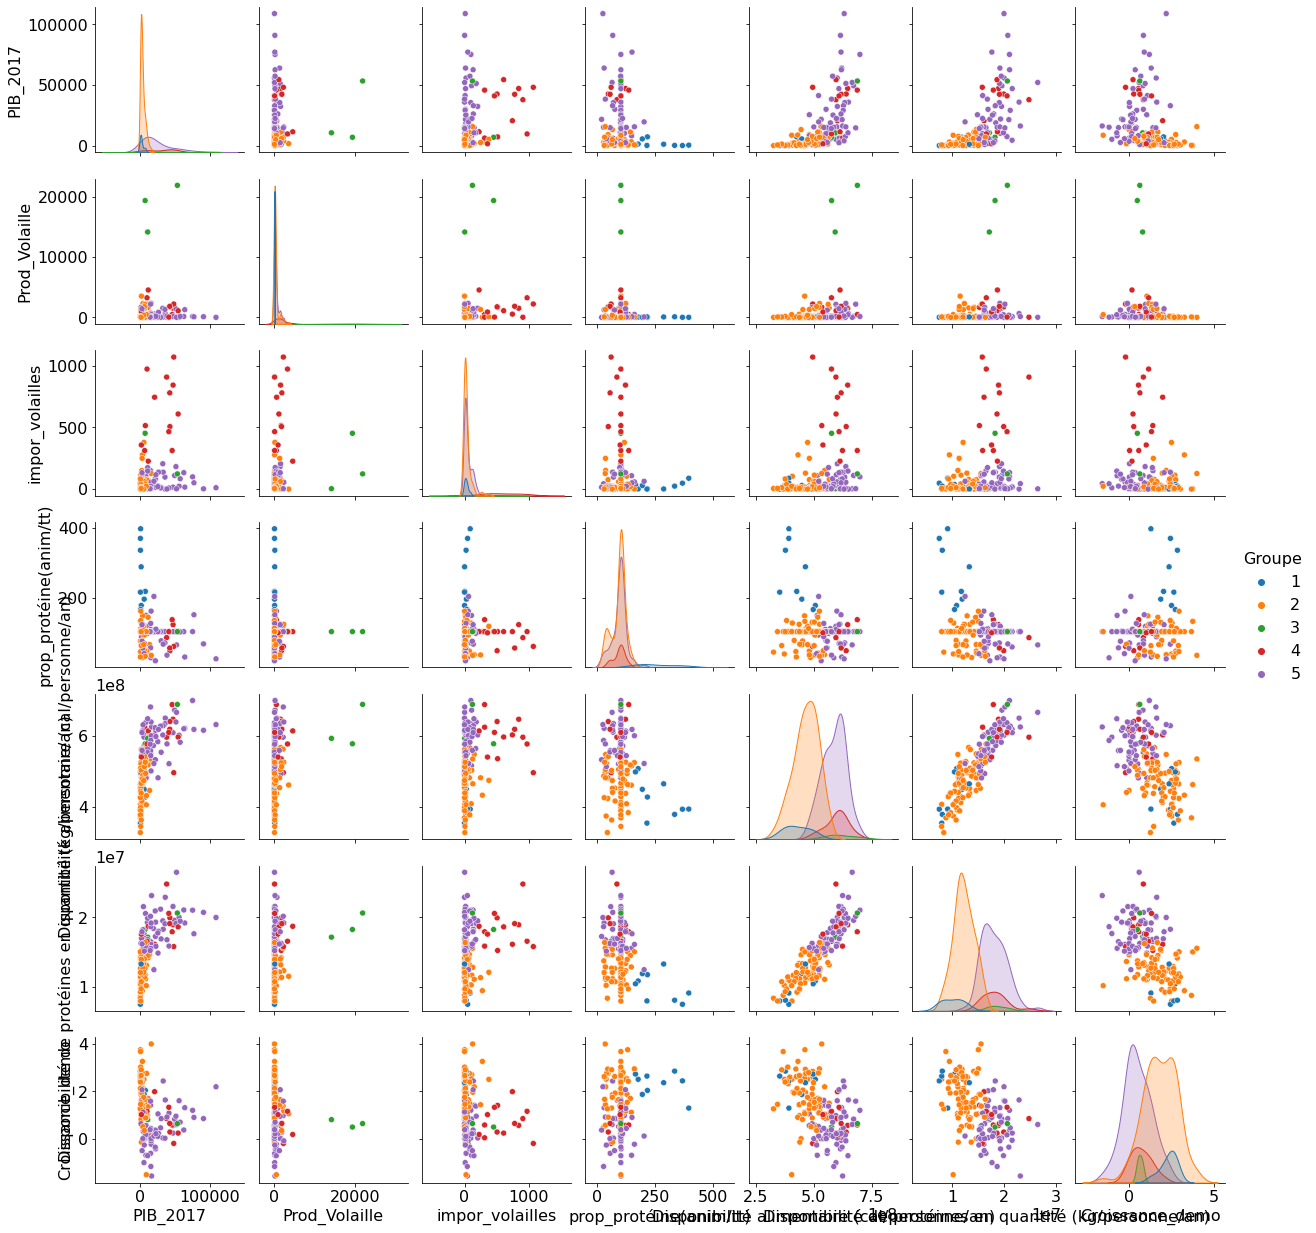

In [61]:
# on va observe l'importance de chaque groupe
sns.pairplot(Dern,hue="Groupe")
plt.savefig("image_groupée")
plt.show()

###### on voit sur la diagonale  les fonctions de densité conditionnaire qui nous permet de savoir l'impact de chaque variable dans la formation des clusters  (groupes)

<ipython-input-62-0ba12e9b9a83>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters2.astype(np.float), cmap = 'jet', alpha=0.5)


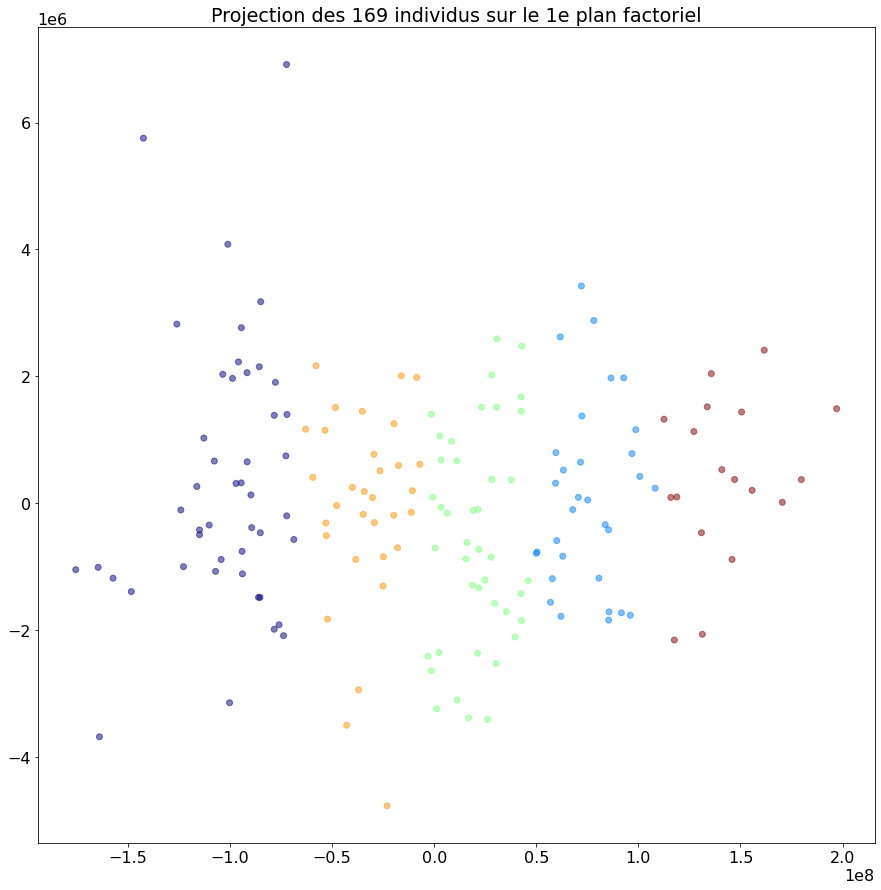

In [62]:
#Affichage du clustering par projection des individus sur le premier plan factoriel:

n_clust = 5
X = Pays.values

km = KMeans(n_clusters=n_clust)
km.fit(X)
clusters2 = km.labels_

pca = decomposition.PCA(n_components=5).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters2.astype(np.float), cmap = 'jet', alpha=0.5)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

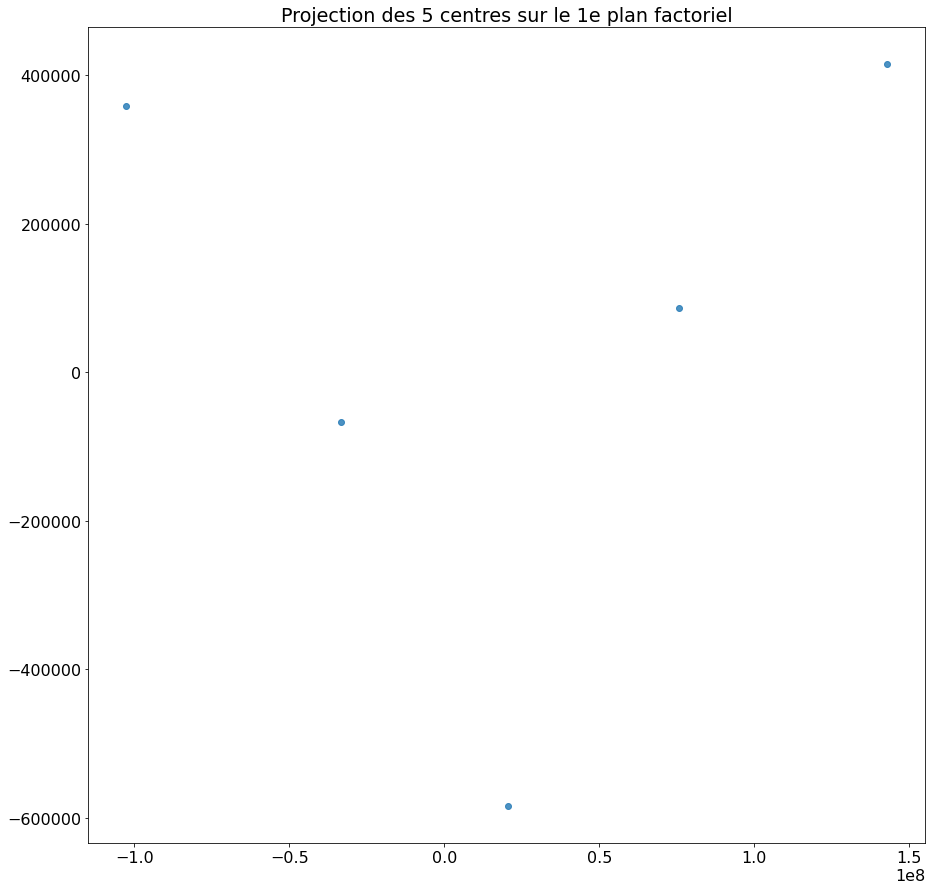

In [63]:
#Affichage des positions des centres de classes sur le plan factoriel:
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1],cmap = 'jet',alpha=0.8)
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.savefig("image_centroides")
plt.show()

# Analyse en composantes principales (ACP)

In [64]:
Dern.columns

Index(['Pays', 'PIB_2017', 'Prod_Volaille', 'impor_volailles',
       'prop_protéine(anim/tt)', 'Disponibilité alimentaire (cal/personne/an)',
       'Disponibilité de protéines en quantité (kg/personne/an)',
       'Croissance_demo', 'Groupe'],
      dtype='object')

### K-means

In [65]:
#standardisation(centre et réduit)
Z = (Pays - Pays.mean(axis=0))/Pays.std(axis=0)
print(Z)

                       PIB_2017  Prod_Volaille  impor_volailles  \
Pays                                                              
Afghanistan           -0.692336      -0.274184        -0.322825   
Afrique du Sud        -0.336533       0.369217         2.268275   
Albanie               -0.478405      -0.280079        -0.370907   
Algérie               -0.476691      -0.168457        -0.467071   
Allemagne              1.713961       0.309869         4.020607   
...                         ...            ...              ...   
Émirats arabes unis    1.399413      -0.266716         2.006494   
Équateur              -0.452837      -0.151556        -0.477756   
États-Unis d'Amérique  2.032105       8.327817         0.179368   
Éthiopie              -0.698952      -0.257283        -0.472414   
Îles Salomon          -0.647829      -0.285189        -0.451044   

                       prop_protéine(anim/tt)  \
Pays                                            
Afghanistan                   

In [66]:
#cluster de 110
res =cluster.KMeans(n_clusters=10)
res.fit(Z)

KMeans(n_clusters=10)

In [67]:
#num. de cluster affectés aux groupes
res.labels_

array([7, 1, 8, 6, 1, 7, 2, 1, 6, 2, 3, 3, 6, 2, 0, 2, 3, 0, 0, 8, 9, 4,
       2, 0, 8, 0, 0, 0, 0, 3, 6, 1, 3, 4, 2, 0, 7, 2, 2, 8, 9, 3, 2, 2,
       8, 8, 0, 2, 3, 1, 8, 0, 7, 0, 0, 8, 0, 9, 7, 2, 2, 5, 0, 8, 0, 0,
       6, 0, 3, 3, 3, 8, 2, 1, 0, 6, 7, 0, 2, 6, 0, 8, 0, 5, 8, 3, 2, 9,
       0, 7, 9, 8, 6, 2, 0, 1, 0, 8, 5, 2, 9, 0, 9, 7, 3, 2, 3, 0, 0, 7,
       6, 0, 0, 7, 0, 1, 0, 8, 2, 8, 0, 8, 1, 7, 7, 8, 2, 0, 0, 7, 2, 2,
       2, 2, 7, 2, 7, 2, 8, 9, 2, 3, 0, 3, 7, 7, 7, 8, 2, 7, 7, 2, 6, 0,
       6, 2, 2, 7, 2, 6, 7, 7, 7, 6, 1, 0, 4, 7, 7])

In [68]:
#identification du nombre de groupes -- 1 à 10
#coude = KElbowVisualizer(res,k=(1,5),metric='distortion',timings=False)
#calculs
#coude.fit(Z)

###### k=4 c'est à dire qu'il ya quatre facteurs( variables qu'il faut prendre en compte )  selon la méthode de k_means

In [69]:
#ici je vais choisir les variables que j'ai jugé utile
for idx,column in enumerate(Dern.columns):
       print(idx,column)

0 Pays
1 PIB_2017
2 Prod_Volaille
3 impor_volailles
4 prop_protéine(anim/tt)
5 Disponibilité alimentaire (cal/personne/an)
6 Disponibilité de protéines en quantité (kg/personne/an)
7 Croissance_demo
8 Groupe


In [70]:
#création de dataframe avec les variables de mon choix 
dern=Dern.iloc[:,[1,3,4,5,6,7]]

In [71]:
# choix du nombre de composantes à calculer
n_comp = 6

In [72]:
# selection des colonnes à prendre en compte dans l'ACP
data_pca =dern[['impor_volailles','PIB_2017','prop_protéine(anim/tt)', 'Disponibilité alimentaire (cal/personne/an)','Croissance_demo', 'Disponibilité de protéines en quantité (kg/personne/an)']]

In [73]:
# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
# ou data.index pour avoir les intitulés
names =Dern["Pays"]

In [74]:
features = dern.columns
features

Index(['PIB_2017', 'impor_volailles', 'prop_protéine(anim/tt)',
       'Disponibilité alimentaire (cal/personne/an)',
       'Disponibilité de protéines en quantité (kg/personne/an)',
       'Croissance_demo'],
      dtype='object')

In [75]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [76]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

## *Analyse d'eboulis des valeurs propres

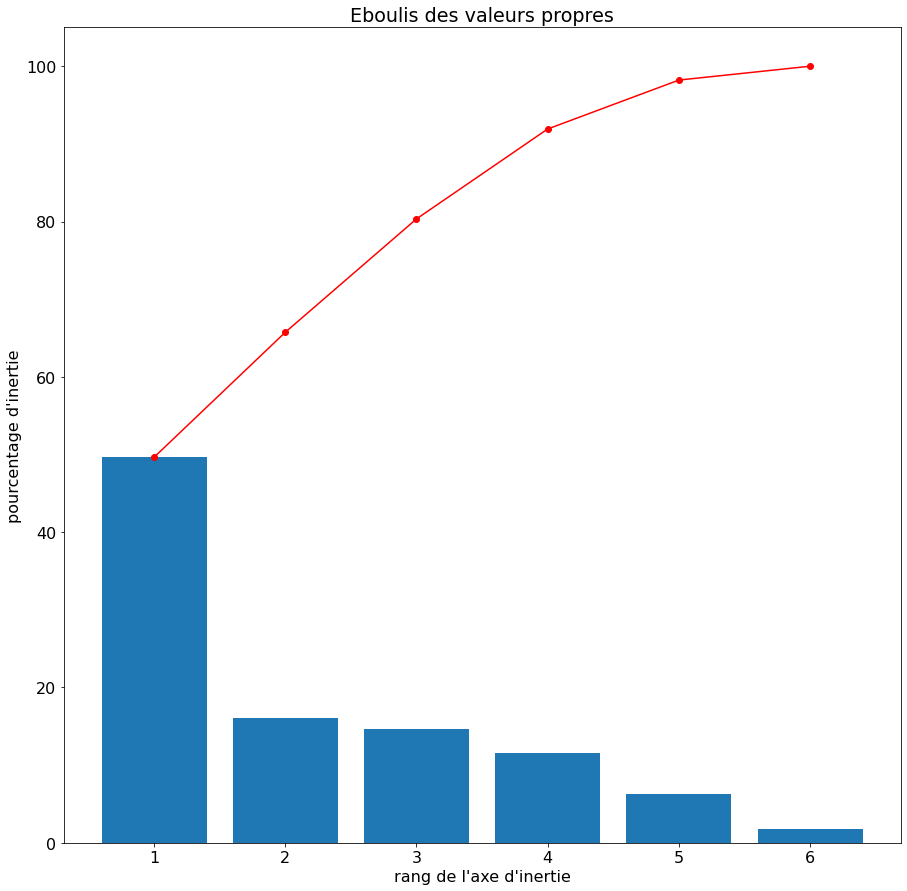

In [77]:
# Eboulis des valeurs propres
display_scree_plot(pca)
plt.show()

In [78]:
# Inertie cumulées des axes factoriels
pca.explained_variance_ratio_.cumsum().round(2)

array([0.5 , 0.66, 0.8 , 0.92, 0.98, 1.  ])

##### le  1 er plan factoriel explique 75 % des données,donc c'est assez

## * Presentation des variables par Cercle des corrélations

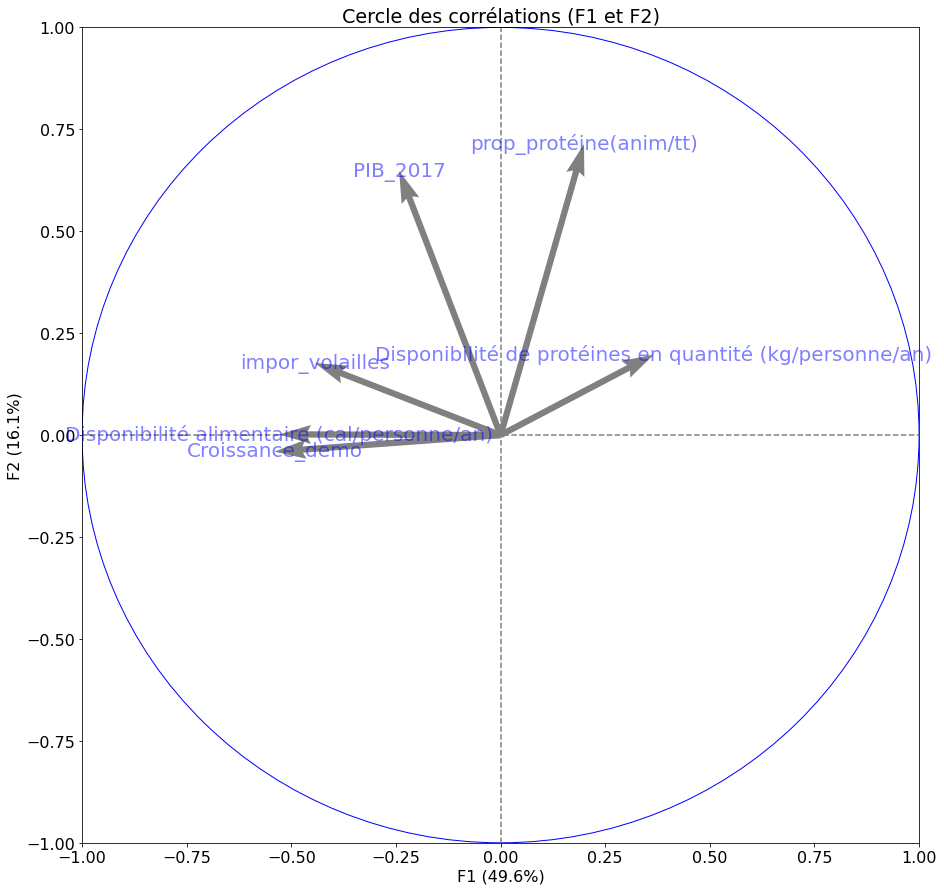

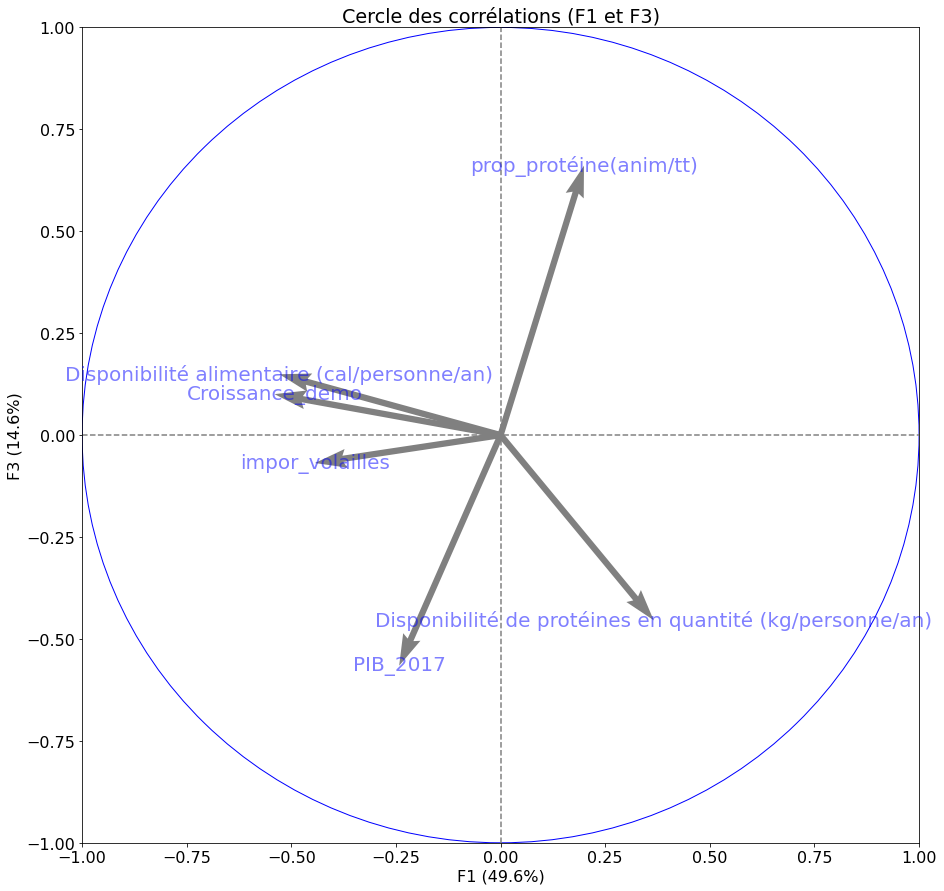

In [79]:
# Cercle des corrélations
plt.rcParams['figure.figsize'] = [1, 1]
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(0,2)], labels = np.array(features))

##### on remarque qu'il y a une corrélation positive entre F1 et  la proportion de protéine animal
##### on remarque  qu'il y a une corrélation positive entre F2 et la croissance demo,PIBpar hab,disponibilité calorie et corrélation négative avec dispo_protein
#####  donc plus on monte plus ,plus i y a une augmentation des F1(proportion protéine animal) et plus on va à droite plus il y a une augmentation F2(Pib par hab,croissance_démographique et disponibilité en calorie)
##### plus on va à gauche plus  la disponibilité en protéine  est grande
###### les pays qui vont nous intéresse seront dans le cadran haut droite là où il y a une croissance de la ppulation,PIB par habit grand ,dispo_calorie est grande et la proportion protéine animal est grande aussi

## * representation des individus par plan factoriel 

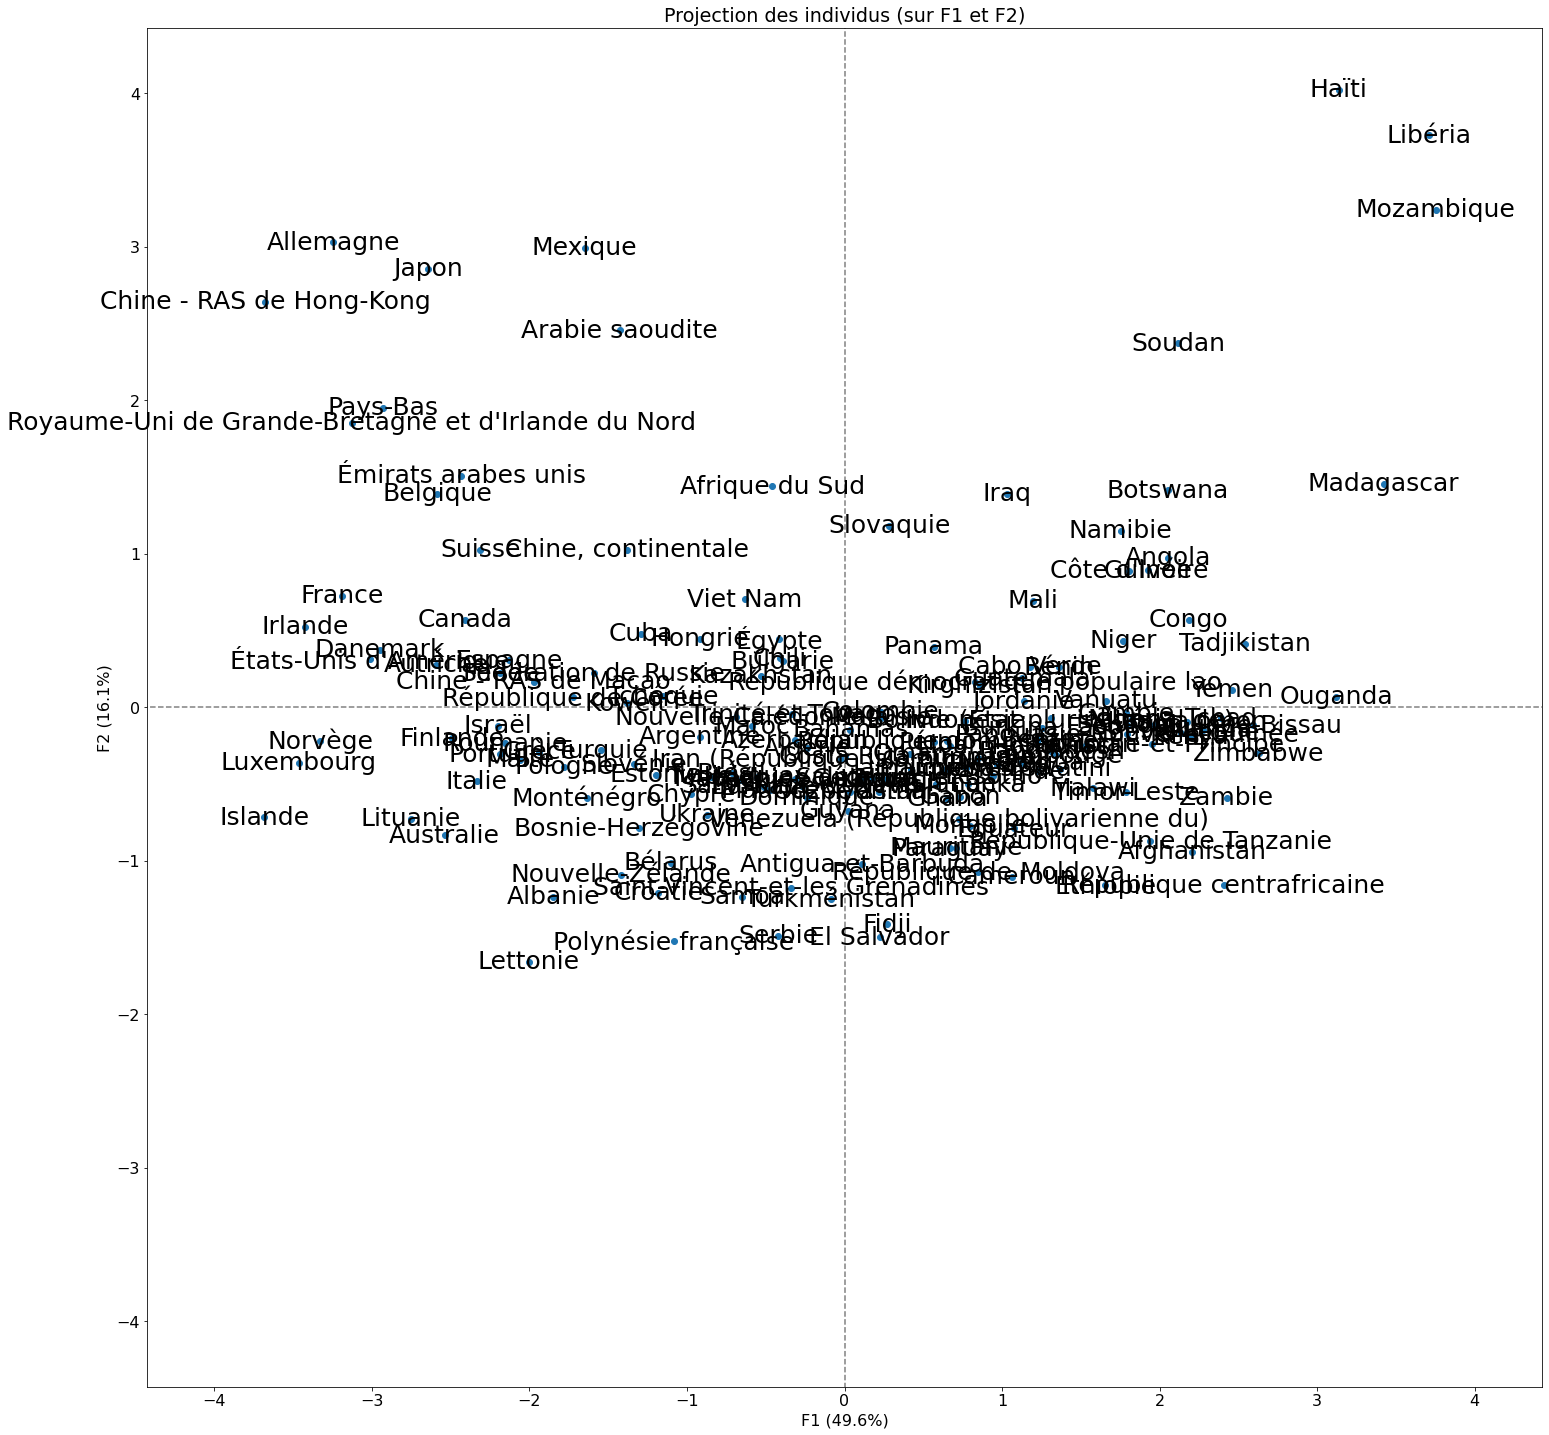

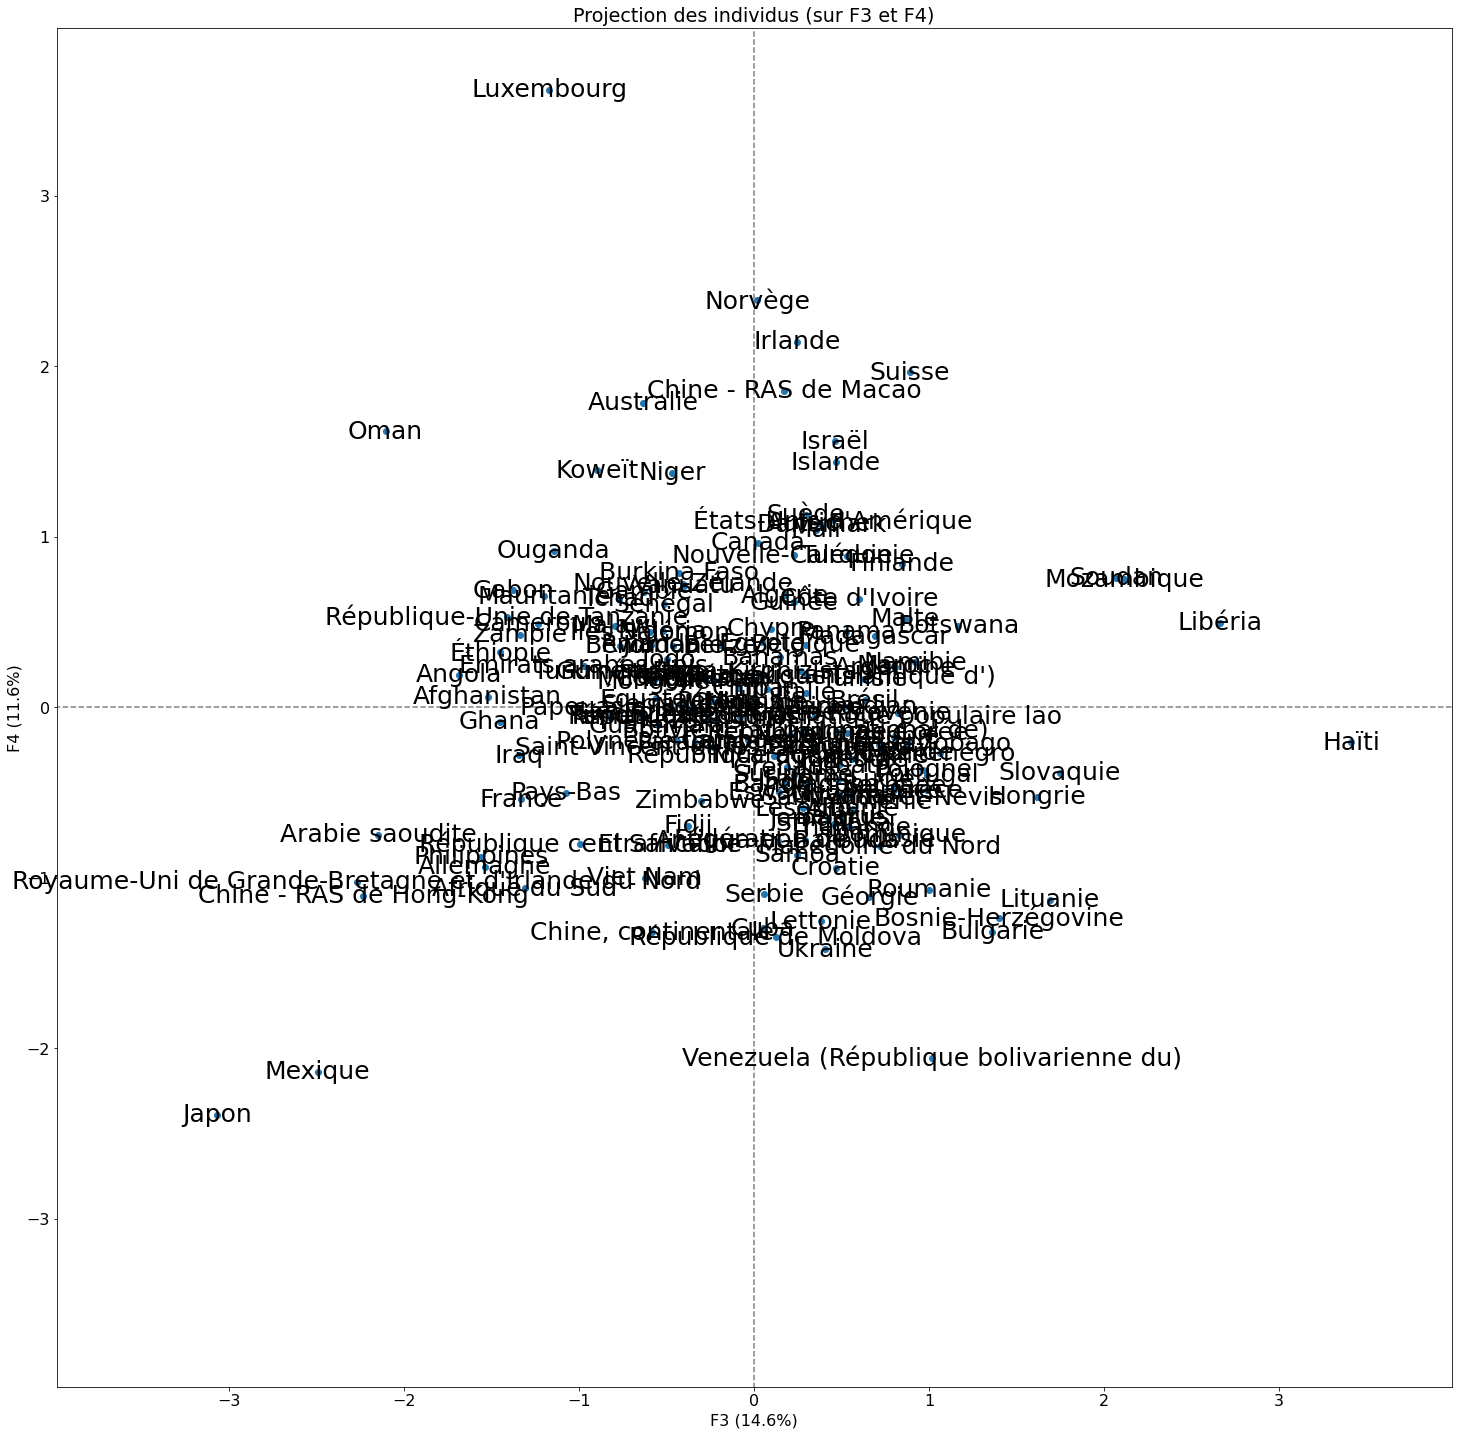

In [80]:
# Projection des individus pour la 1 ere plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)],labels = np.array(names))
plt.show()

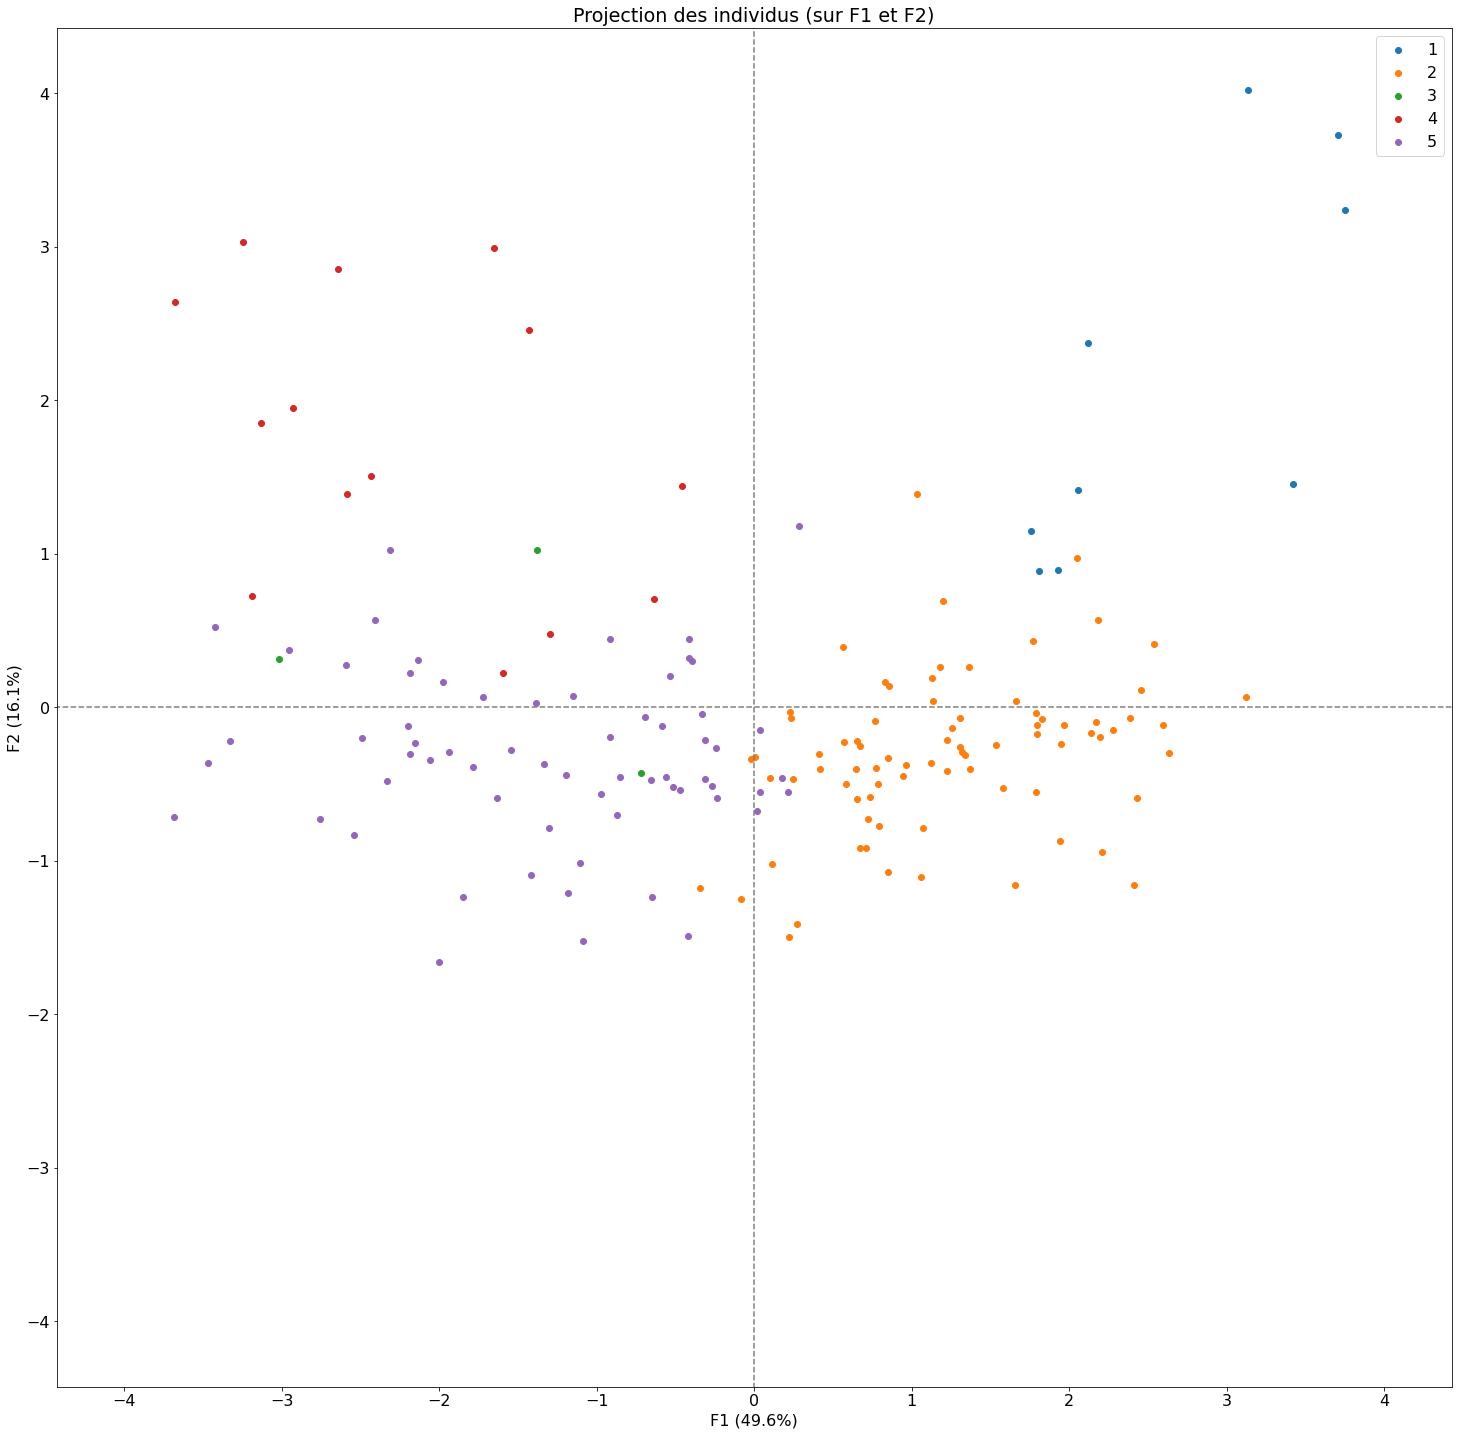

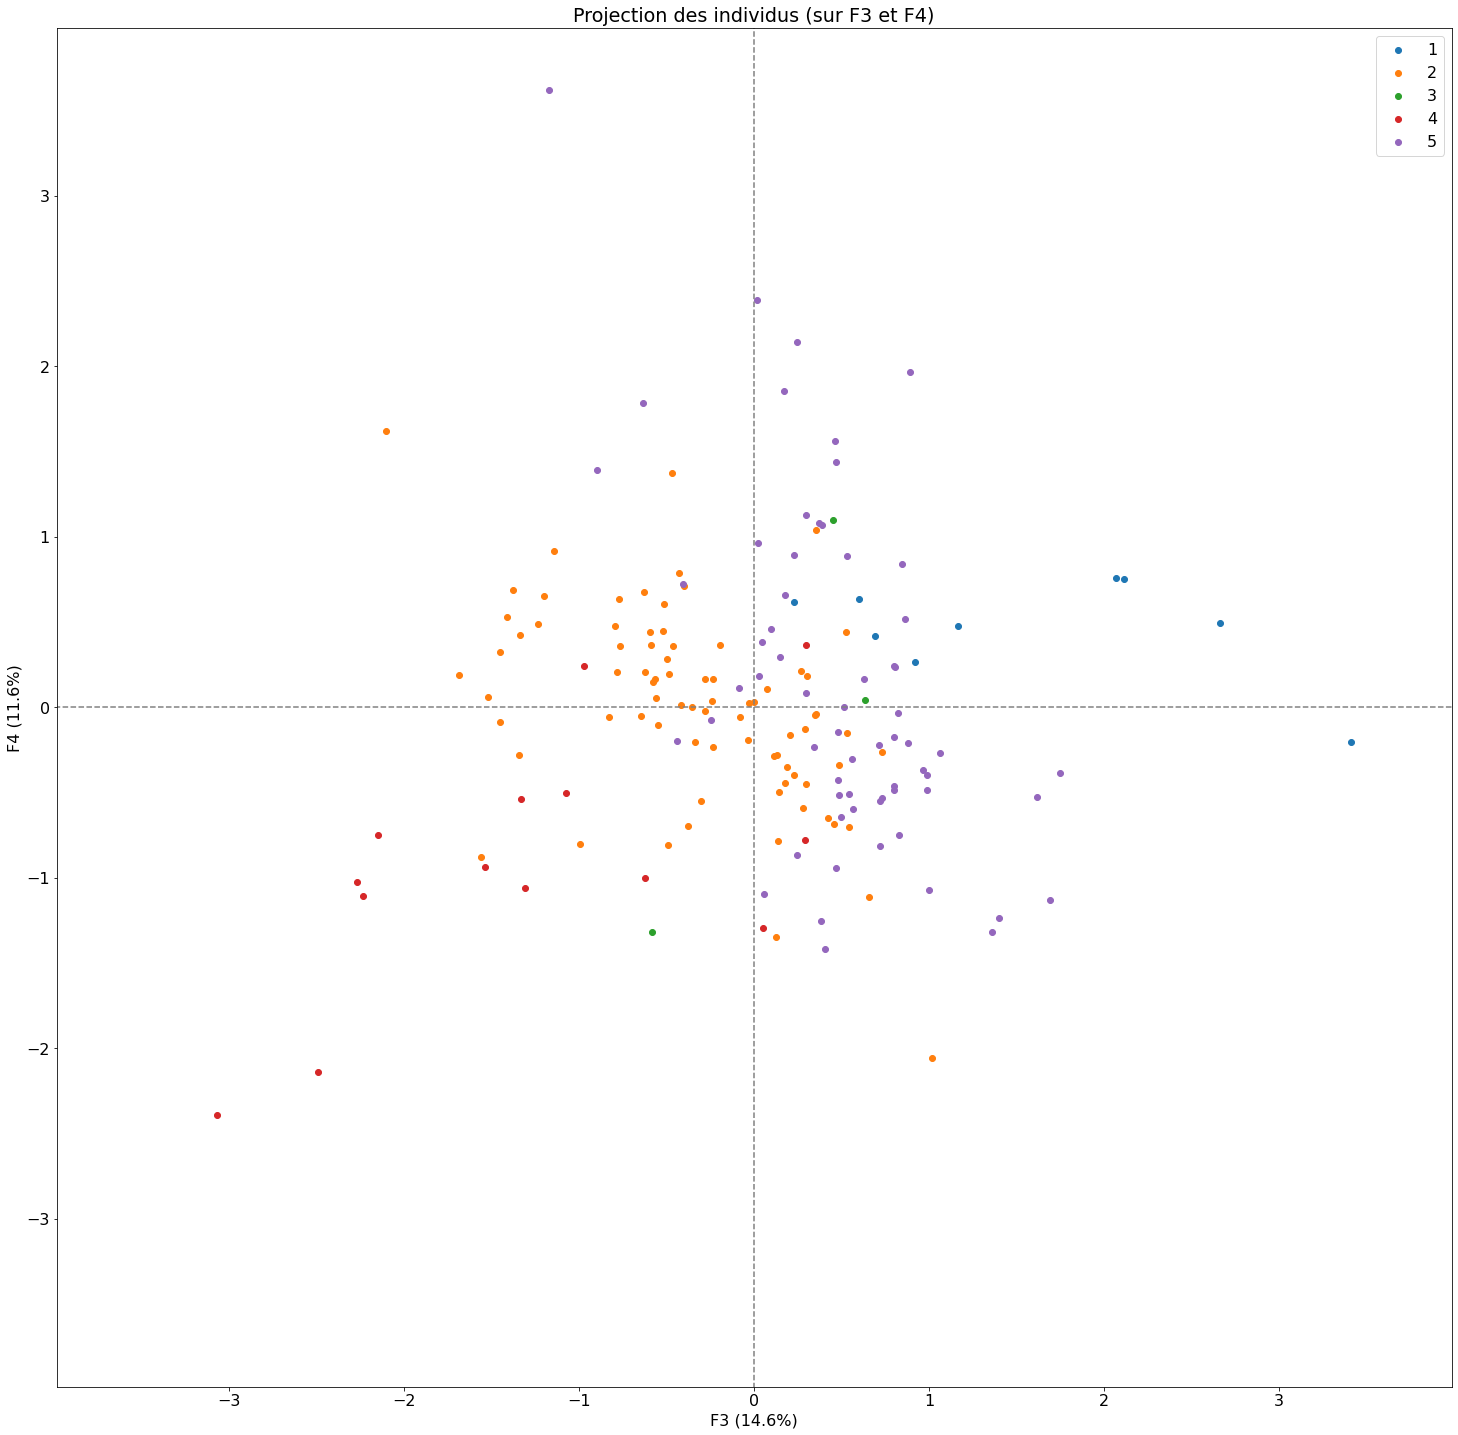

In [81]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = groupes_cah)
plt.show()

######  on voit que les pays conserne sont des pays de groupe 4,majoritairement 5 sont tout dans le cadran superieur droit  de la 1 ere plan factoriel ,alors il va faloir creuse car on a deux groupes 

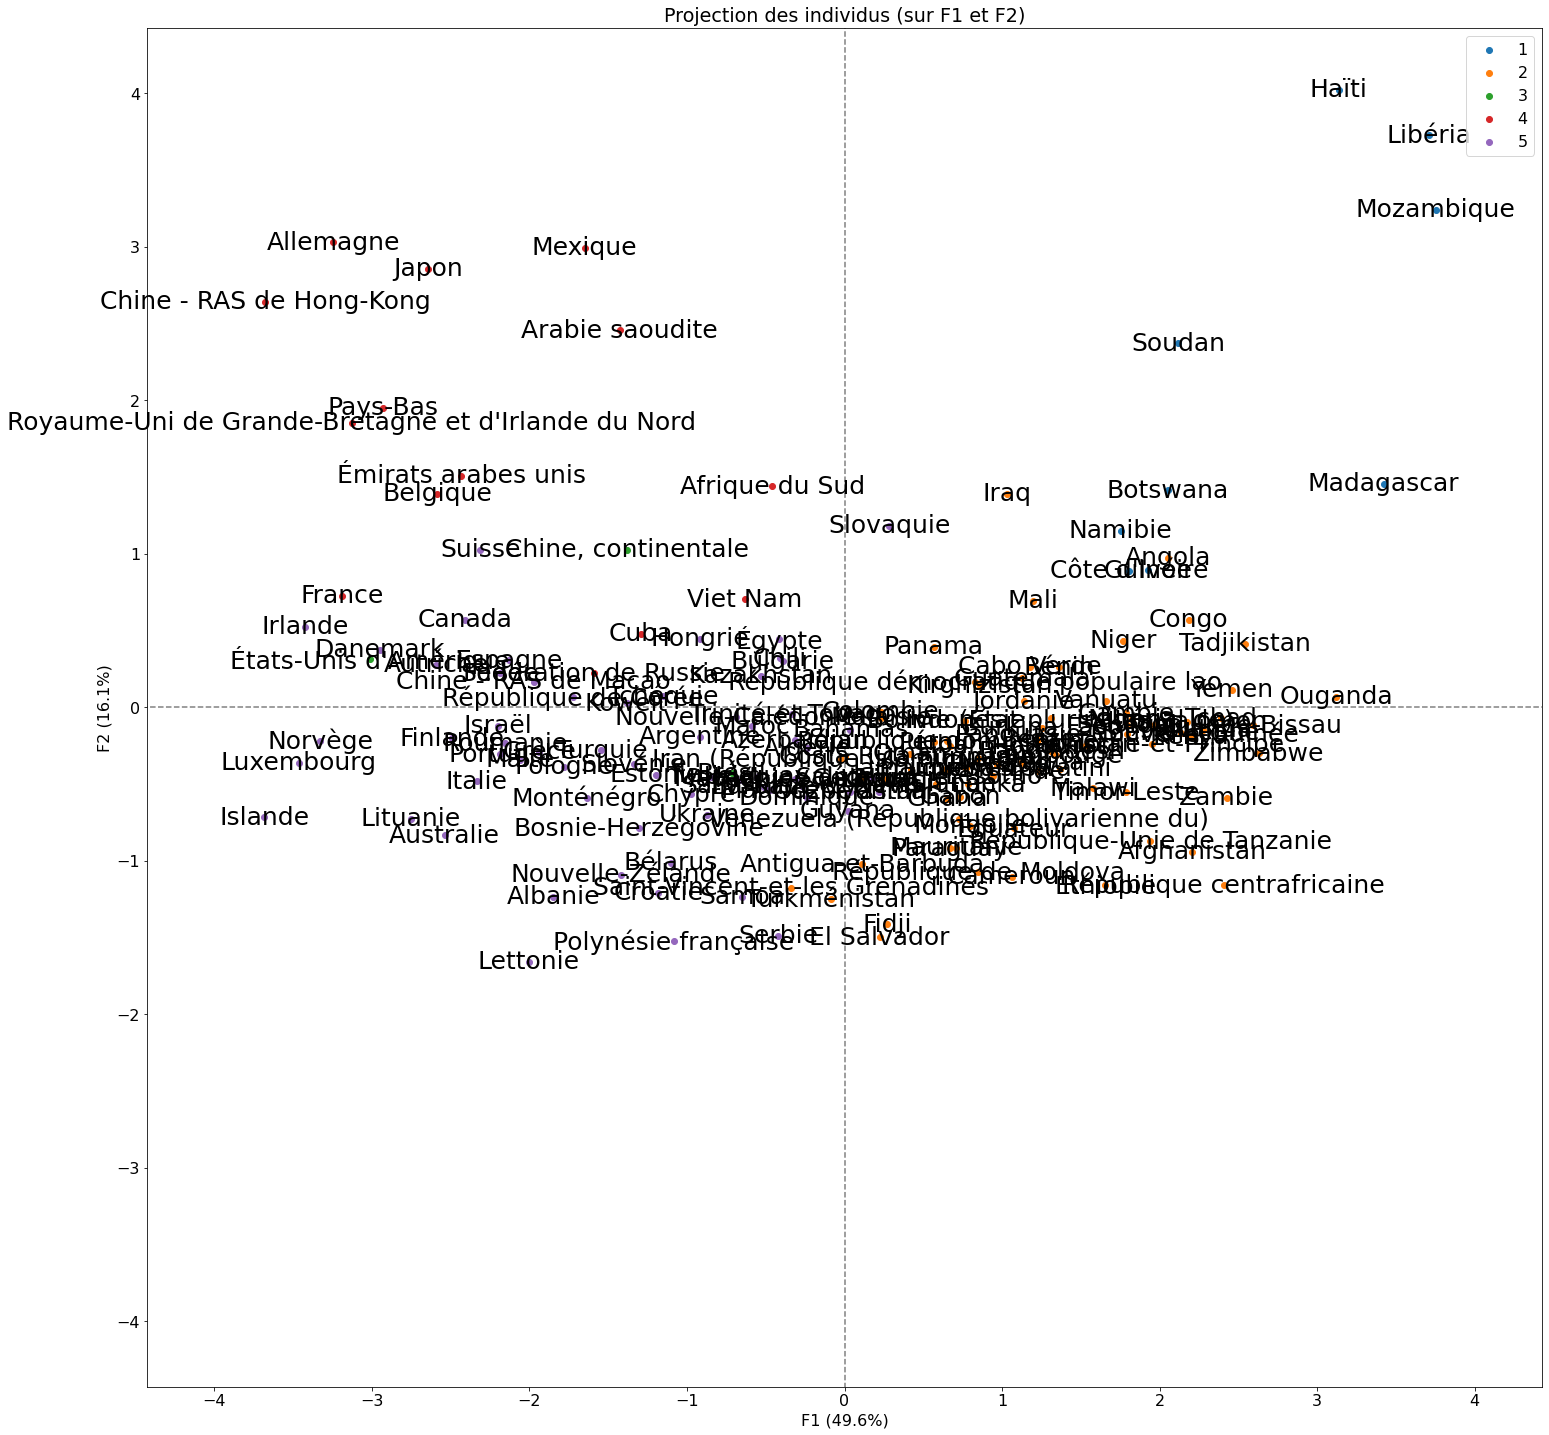

In [82]:
#pays du cadran sup droit sur le 1 ér plan factoriel
display_factorial_planes(X_projected,7,pca,[(0,1)],illustrative_var=groupes_cah,labels=np.array(names))


 On va choisir les pays qui se trouve dans le le cadran haut droit où il y a beaucoups des pays developper avec une grande pouvoir d'achat,pour le soucis de transport je propose les tois pays plus prochain de la France dont Suisse ,Belgique,allemagne et Pays_bas.

# un test d'adéquation ( la loi normale)

## Pour tester l’adéquation à une loi normale on utilise test Kolmogorov-Smirnov

In [83]:
# test de normalité par Kolmogorov-Smirnov  de  variable de proportion de ptotéine animal_tt
ks_2samp(Dern['prop_protéine(anim/tt)'],list(np.random.normal(np.mean(Dern['prop_protéine(anim/tt)']), np.std(Dern['prop_protéine(anim/tt)']),1000)))

KstestResult(statistic=0.2889822485207101, pvalue=3.5964675682009783e-11)

#### On  peut donc  rejetter l’hypothèse de normalité au niveau de test 5% car p_values est proche de 0

In [84]:
# test de normalité par Kolmogorov-Smirnov de disponibilité en quantité protéine par personne
ks_2samp(Dern['Disponibilité alimentaire (cal/personne/an)'],list(np.random.normal(np.mean(Dern['Disponibilité de protéines en quantité (kg/personne/an)']), np.std(Dern['Disponibilité de protéines en quantité (kg/personne/an)']),1000)))

KstestResult(statistic=1.0, pvalue=0.0)

#### On  ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5% car le p_value est proche de 1

In [85]:
# test de normalité par Kolmogorov-Smirnov de disponibilité en quantité calorie par personne
ks_2samp(Dern['Disponibilité alimentaire (cal/personne/an)'],list(np.random.normal(np.mean(Dern['Disponibilité alimentaire (cal/personne/an)']), np.std(Dern['Disponibilité alimentaire (cal/personne/an)']),1000)))

KstestResult(statistic=0.08827218934911242, pvalue=0.19654721361330552)

#### On  ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5% car le p_value est proche de 1

In [86]:
# test de normalité par Kolmogorov-Smirnov de disponibilité en quantité calorie par personne
ks_2samp(Dern['Croissance_demo'],list(np.random.normal(np.mean(Dern['Croissance_demo']), np.std(Dern['Croissance_demo']),1000)))

KstestResult(statistic=0.07619526627218935, pvalue=0.3508204613279604)

#### On  ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5% car le p_value est proche de 1

##### En conclusion les variables Dispo_calorie ,(Disponibilité de protéines en quantité (kg/personne/an)  )et (Croissance_demo) suivent  une loi normale centre et réduite .

# Test de comparaison de deux populations (dans le cas gaussien)

In [87]:
Dern

,Pays,PIB_2017,Prod_Volaille,impor_volailles,prop_protéine(anim/tt),Disponibilité alimentaire (cal/personne/an),Disponibilité de protéines en quantité (kg/personne/an),Croissance_demo,Groupe
0,Afghanistan,624.105029,28,29,39.658241,373760000.0,10252850.0,2.515429,2
1,Afrique du Sud,7525.516250,1665,514,103.460000,535455000.0,15260650.0,1.406771,4
2,Albanie,4773.659501,13,20,59.769726,618492500.0,21556900.0,-0.069348,5
3,Algérie,4806.918145,297,2,103.460000,609550000.0,16937825.0,2.024693,5
4,Allemagne,47298.378965,1514,842,123.425159,646962500.0,18947150.0,0.561349,4
...,...,...,...,...,...,...,...,...,...
164,Émirats arabes unis,41197.178798,47,465,103.460000,609732500.0,20584175.0,1.328133,4
165,Équateur,5269.600089,340,0,66.355703,473952500.0,12128950.0,1.751564,2
166,États-Unis d'Amérique,53469.316622,21914,123,103.460000,688755000.0,20640750.0,0.636449,3
167,Éthiopie,495.773654,71,1,31.103729,425590000.0,12086975.0,2.628759,2


In [88]:
# on selectionne les groupes (les échantillons)
grp_1 = Dern[Dern["Groupe"]== 4]["prop_protéine(anim/tt)"]
grp_2 = Dern[Dern["Groupe"]== 5]["prop_protéine(anim/tt)"]

In [89]:
# On teste tout d’abord l’égalité des variances à l’aide de la commande
stats.bartlett(grp_1,grp_2)

BartlettResult(statistic=1.1224862537947295, pvalue=0.28938372841084153)

#### La p-valeur valant 0.289 , on ne rejette donc pas l’égalité des variances au niveau de test 5%

In [90]:
# On teste ensuite l’égalité des moyennes à l’aide de la commande
stats.ttest_ind(grp_1,grp_2, equal_var=True)

Ttest_indResult(statistic=-0.0422805029770841, pvalue=0.9663859711881965)

#### La p-valeur valant 0.96 , on ne rejette donc pas l’égalité des moyennes au niveau de test 5%

##### vu que il y a l'égalité des variances et des moyennes on a deux échantillions gaussiens qui ont la même distributions